## Import libraries

In [1]:
import glob
from tqdm import tqdm
import datetime
import re
import pandas as pd
import seaborn as sns
import warnings
import os
import pickle
import numpy as np
import utils as ut
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.patches as mpatches
import matplotlib
from scipy import stats
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, MaxNLocator
import PA_Utils as pa_ut
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from scipy.stats import ttest_1samp

## Functions

In [2]:
def get_animal_data(data_path, Animal_ID, protocol, data_type):
    """
    Args:
        data_path (str): path to the data folder
        Animal_ID (str): animal ID
        protocol (str): protocol name
        data_type (str): data type (e.g. 'Trial_Summary', 'Detected_Licks')
    Returns:
        animal_df (pd.DataFrame): dataframe containing all the data for the animal
    """

    subject_folders = glob.glob(data_path + Animal_ID +'/*') 
    protocol_folders = list(filter(lambda x: protocol in x, subject_folders)) 

    if len(protocol_folders) == 0:
        warnings.warn(f"{Animal_ID}: all_folders empty")
        return 0

    sessions_data = []
    for folder in tqdm(protocol_folders, position=0, leave=True, desc = 'Processing ' + Animal_ID ):  
        folder_files = glob.glob(folder +'/**/'+data_type +'*.csv', recursive = True)
        for file in folder_files:
            try:
                session_df = pd.read_csv(file)
                date_pattern = r'\d{4}_\d{1,2}_\d{1,2}'
                date = re.search(date_pattern, file).group(0)
                date_obj = datetime.datetime.strptime(date, '%Y_%m_%d')
                formatted_date = date_obj.strftime('%Y/%m/%d')
                session_df.insert(0, 'Date', formatted_date)
                session_df['File_ID'] = file  # Add file identifier
                sessions_data.append(session_df)
            except pd.errors.EmptyDataError:
                pass

        animal_df = pd.concat(sessions_data, axis=0, ignore_index=True)
        # Create a list of columns for sorting
        sort_columns = ['Date']

        # Check which of the columns ('Trial_End_Time' or 'Time') exists in the DataFrame
        if 'Trial_End_Time' in animal_df.columns:
            sort_columns.append('Trial_End_Time')
        elif 'Time' in animal_df.columns:
            sort_columns.append('Time')

        # Sort the DataFrame by the determined columns
        animal_df = animal_df.sort_values(by=sort_columns)

        date_list = []
        for date in animal_df.Date.unique():
            date_df = animal_df[animal_df.Date == date].reset_index(drop=True)
            date_list.append(date_df)
            
        animal_df = pd.concat(date_list, axis=0, ignore_index=True)

    return animal_df

def remap_values(df, column_info):
    '''
    Remaps values in a dataframe according to the value_mapping dict in column_info
    Args:
        df (pd.DataFrame): dataframe to be remapped
        column_info (dict): dictionary containing information about the columns
    Returns:
        df (pd.DataFrame): remapped dataframe
    '''
    for col, info in column_info.items():
        if col in df.columns and info['value_mapping']:
            for new_val, old_vals in info['value_mapping'].items():
                df[col] = df[col].replace(old_vals, new_val)
    return df

def check_and_convert_dtypes(df, column_info):
    '''
    Checks if the dtypes of the columns in the dataframe match the expected dtypes in column_info
    and converts them if necessary
    Args:
        df (pd.DataFrame): dataframe to be checked
        column_info (dict): dictionary containing information about the columns
    Returns:
        df (pd.DataFrame): dataframe with converted dtypes
    '''
    for col, info in column_info.items():
        if col in df.columns:
            expected_dtype = info['dtype']
            if df[col].dtype != expected_dtype:
                try:
                    df[col] = df[col].astype(expected_dtype)
                except ValueError:
                    print(f"Warning: Could not convert column {col} to {expected_dtype}")
    return df

def standardize_dataframe(df, column_info):
    '''
    Standardizes the dataframe by renaming columns, filtering columns, remapping values and converting dtypes
    If certain columns are missing, they are added (potentially future arguments to choose whether to add them or not)
    Args:
        df (pd.DataFrame): dataframe to be standardized
        column_info (dict): dictionary containing information about the columns
    Returns:
        cleaned_df (pd.DataFrame): standardized dataframe
    '''
    rename_dict = {old_name: new_name for new_name, info in column_info.items() if info['rename'] for old_name in info['rename']}

    cleaned_df_list = []

    # look through all File_IDs and re-index the 'Trial' column, then re-assign the df
    for file_id in df['File_ID'].unique():
        file_df = df[df['File_ID'] == file_id]
        # drop all columns that are fully NaN
        file_df = file_df.dropna(axis=1, how='all')
        # rename columns
        file_df = file_df.rename(columns=rename_dict)
        # only keep columns that are in the column_info dict
        # file_df = file_df[[col for col in file_df.columns if col in column_info]]

        # remap values
        file_df = remap_values(file_df, column_info)

        file_df = check_and_convert_dtypes(file_df, column_info)

        # re-index the 'Trial' column
        file_df['Trial'] = file_df['Trial'].rank(method='dense').astype('Int64')
        # Special handling for the 'choice' column
        if 'choice' in file_df.columns and 2 in file_df['choice'].values:
            file_df['choice'] = file_df['choice'] - 1

        # if 'trial_outcome' is missing, add it
        if 'Trial_Outcome' not in file_df.columns:
            # check if 'correct' and 'no_response' are present
            if 'correct' in file_df.columns and 'no_response' in file_df.columns:
            #     # Define conditions
            #     conditions = [
            #         (file_df['correct'] == 1) & (file_df['no_response'] == False),
            #         (file_df['correct'] == 0) & (file_df['no_response'] == False),
            #         file_df['no_response'] == True
            #     ]
                
            #     # Define choices corresponding to conditions
            #     outcomes = ['Correct', 'Incorrect', 'No_Response']
                
            #     # Use numpy select to apply conditions and choices
            #     file_df['Trial_Outcome'] = np.select(conditions, outcomes, default='Unknown')
            # else:
            #     file_df['Trial_Outcome'] = np.nan

                file_df.loc[(file_df['correct'] == 1) & ~file_df['no_response'], 'Trial_Outcome'] = 'Correct'
                file_df.loc[(file_df['correct'] == 0) & ~file_df['no_response'], 'Trial_Outcome'] = 'Incorrect'
                file_df.loc[file_df['no_response'], 'Trial_Outcome'] = 'No_Response'
                file_df['Trial_Outcome'].fillna('Unknown', inplace=True)

        if 'Stim_Relative' not in file_df.columns and 'WN_Amp' in file_df.columns:
            file_df['Stim_Relative'] = file_df['WN_Amp'].apply(lambda x: convert_value(x, 
                                                                                       original_min=50, original_max=82, 
                                                                                       new_min=-1, new_max=1))
        if 'Nb_Of_Stim' not in file_df.columns and file_df['Stage'].iloc[0] != 'Full_Task_Cont':
            try:
                file_df['Nb_Of_Stim'] = len(file_df.Stim_Relative.unique()) 
            except AttributeError:
                file_df['Nb_Of_Stim'] = np.nan
 
        # only keep columns that are in the column_info dict
        file_df = file_df[[col for col in file_df.columns if col in column_info]]

        cleaned_df_list.append(file_df)

        

    cleaned_df = pd.concat(cleaned_df_list, ignore_index=True)
    return cleaned_df

def convert_value(original_value, original_min=50, original_max=82, new_min=-1, new_max=1):
    # Translate original_value to the new range
    return (original_value - original_min) * (new_max - new_min) / (original_max - original_min) + new_min

def calculate_sem_binomial(p, n):
    return np.sqrt(p * (1 - p) / n)

## Set plot fonts

In [3]:
ut.set_plot_font(font_family='sans-serif', title_font_size=14, label_font_size=14, sans_serif_font='Helvetica')

In [4]:
# BReak execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Fetch Data

In [5]:
Animal_List = data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
protocol = 'PRO_ANTI'
data_type = 'Trial_Summary'

Animal_List = [
              'QP069', 
              'QP070', 'QP077', 'QP083', 'QP084', 'QP085', 'QP090', 'QP091', 'QP092',  'QP0104',  'QP0105', 'QP0106', 'QP0107', 'QP0108', 
              'QP0112'
              ]

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_PA.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data_PA = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_PA = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = get_animal_data(data_path,
                                             animal, 
                                             protocol,
                                             data_type)
            all_data_PA = pd.concat([all_data_PA, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_PA, f)

Processing QP0112: 100%|██████████| 17/17 [00:05<00:00,  3.34it/s]


In [ ]:
PA_column_info = {
    'Date': {'dtype': str, 
             'rename': None, 
             'value_mapping': None},
    'Participant_ID': {'dtype': str, 
                       'rename': ['Animal_ID'], 
                       'value_mapping': None},
    'Protocol': {'dtype': str,
                 'rename': None,
                 'value_mapping': None},
    'Stage': {'dtype': str,
                'rename': None,
                'value_mapping': {'Habituation': [1, 'Habituation', 'Stage_1'],
                                  'Lick_To_Release': [2, 'Lick_To_Release', 'Stage_2'],
                                  'Three_And_Three': [3, 'Three_And_Three', 'Stage_3'],
                                  'Full_Task_Disc': [4, 'Full_Task_Disc', 'Stage_4'],
                                  'Full_Task_Cont': [5, 'Full_Task_Cont', 'Stage_5']}},
    'Trial': {'dtype': 'Int64',
              'rename': ['TrialNumber', 'Trial_Number'],
              'value_mapping': None},
    'choice': {'dtype': 'Int64', 
               'rename': ['FirstLick', 'First_Lick'], 
               'value_mapping': {0: 'Left', 1: 'Right'}},
    'Stim_Relative': {'dtype': float,
                        'rename': None,
                        'value_mapping': None},
    'correct': {'dtype': 'Int64',
                'rename': ['Correct', 'correct'],
                'value_mapping': {1: [True, '1', 'True'],
                                  0: [False, '0', 'False']}},
    'Trial_Outcome': {'dtype': str, 
                      'rename': ['TrialOutcome'], 
                      'value_mapping': {'Correct': ['Correct', 'correct', 1], 
                                        'Incorrect': ['Incorrect', 'incorrect', 0], 
                                        'No_Response': ['No Response', 'no_response', -1, 'Abort']}},
    'no_response': {'dtype': bool,
                    'rename': ['AbortTrial', 'Abort_Trial'],
                    'value_mapping': None},
    'Response_Latency': {'dtype': float,
                        'rename': None,
                        'value_mapping': None},
    'Nb_Of_Stim': {'dtype': 'Int32',
                    'rename': None,
                    'value_mapping': None},
    'Stim_Type': {'dtype': str,
                  'rename': None,
                  'value_mapping': None},
    'Anti_Bias': {'dtype': bool,
                  'rename': ['AntiBias', 'Anti_Bias'],
                  'value_mapping': None},
    'Sound_Contingency': {'dtype': str,
                          'rename': None,
                          'value_mapping': None},
    'P_Right': {'dtype': float,
                'rename': None,
                'value_mapping': None},
    'Distribution': {'dtype': str,
                     'rename': None,
                     'value_mapping': None},
    'Trial_End_Time': {'dtype': float,
                      'rename': ['Time', 'Trial_End_Time'],
                      'value_mapping': None},
    'File_ID': {'dtype': str,   
                'rename': None,
                'value_mapping': None},
    'Air_Puff_Contingency': {'dtype': str,
                             'rename': ['Trial_State'],
                             'value_mapping': {'Pro': [0],
                                                    'Anti': [1]}},
    'Air_Puff_Side': {'dtype': 'Int64', 
                      'rename': ['AirPuff_Side'],
                      'value_mapping': {1: [1, 1.0, 'Right', '1', '1.0'], 
                                        0: [0, 0.0, 'Left', '0', '0.0']}},
                                            
}

pa_df = standardize_dataframe(all_data_PA, PA_column_info)
# only keep rows where 'Participant_ID' is in Animal_List
pa_df = pa_df[pa_df['Participant_ID'].isin(Animal_List)].reset_index(drop=True)

In [ ]:
# Break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Prepare Data

In [ ]:
# remove Date == 2023/10/23 for QP084 (not enough trials)
sub_df = pa_df.reset_index(drop=True)

# remmove no_response trials
sub_df = sub_df[sub_df['no_response'] == False].reset_index(drop=True)

# only keep rows where 'Air_Puff_Contingency' is in ['Pro', 'Anti']
sub_df = sub_df[sub_df['Air_Puff_Contingency'].isin(['Pro', 'Anti'])].reset_index(drop=True)

In [ ]:
participant = 'QP091'
start_date, end_date = '2023/07/20', '2023/09/29'

participant_df = sub_df[(sub_df['Participant_ID'] == participant) & (sub_df['Date'] >= start_date) 
                        & (sub_df['Date'] <= end_date)].reset_index(drop=True)

In [ ]:
grouped_df_mean = participant_df.groupby(['Date', 'Air_Puff_Contingency'])['correct'].mean().reset_index()
grouped_df_mean.sort_values(by='Date', inplace=True)
grouped_df_len = participant_df.groupby(['Date', 'Air_Puff_Contingency'])['correct'].size().reset_index(name='trials')
grouped_df_len.sort_values(by='Date', inplace=True)
merged_df = pd.merge(grouped_df_mean, grouped_df_len, on=['Date', 'Air_Puff_Contingency']).drop_duplicates().reset_index(drop=True)

## Plot

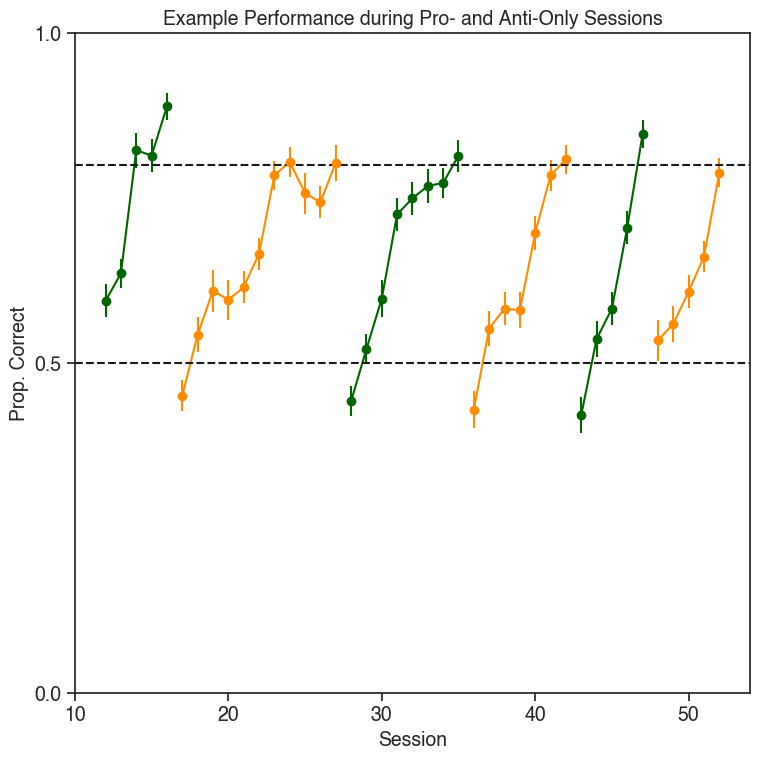

In [ ]:
unique_condition_dates = merged_df.groupby('Date').filter(lambda x: len(x) == 1)

# Plotting with error bars using actual trial numbers
plt.figure(figsize=(8, 8))

for contingency, color in zip(['Pro', 'Anti'], ['darkgreen', 'darkorange']):
    df_subset = unique_condition_dates[unique_condition_dates['Air_Puff_Contingency'] == contingency]
    indices = df_subset.index
    correct_values = df_subset['correct']
    trials = df_subset['trials']

    # Calculating SEM for each point
    sem_values = calculate_sem_binomial(correct_values, trials)

    # Plotting points with error bars
    plt.errorbar(indices, correct_values, yerr=sem_values, fmt='o', color=color, label=contingency)

    # Connect points with lines only if they are consecutive
    for i in range(len(indices) - 1):
        if indices[i + 1] - indices[i] == 1:
            plt.plot(indices[i:i + 2], correct_values[i:i + 2], color=color)

# Adding the dashed lines and other plot configurations
plt.axhline(0.5, color='k', linestyle='--')
plt.axhline(0.8, color='k', linestyle='--')
plt.ylim(0, 1)
plt.xticks(np.arange(10, 60, 10))
plt.yticks(np.arange(0, 1.1, 0.5))
plt.title("Example Performance during Pro- and Anti-Only Sessions")
plt.xlabel("Session")
plt.ylabel("Prop. Correct")
plt.legend().remove()
plt.tight_layout()
# save in figures folder
plt.savefig(figs_path + participant + '_Pro_Only_Anti_Only_Performance.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Fetch Data

In [4]:
data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
protocol = 'PRO_ANTI'
data_type = 'Trial_Summary'

Animal_List = [
            #   'QP069', 
            #   'QP070', 
              'QP077', 
              'QP083', 'QP084', 'QP085', 'QP090', 'QP091', 'QP092',  'QP0104',  'QP0105', 'QP0106', 'QP0107', 
              'QP0108',
                # 'QP0112' 
              ]

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = pa_ut.get_animal_data(data_path,
                                             animal, 
                                             protocol,
                                             data_type)
            all_data = pd.concat([all_data, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data, f)

In [5]:
df = all_data

df['Datetime'] = pd.to_datetime(df['Date'])
date_limit = '2023/09/26'  
df = df[df['Datetime'] >= date_limit]
# reference df for the first session with new protocol
# ref_df = pd.read_csv('/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/QP077/PRO_ANTI_QP077_2023_9_25/Trial_Summary2023-09-25T10_02_59.csv')
# columns_list = ref_df.columns.tolist()
columns_list = ['Animal_ID', 'Protocol', 'Stage', 'Trial_Number', 'Correct_Count', 'Sound_Contingency', 'Stim_Relative', 'Correct', 'Abort_Trial', 'Rule',
                'Reward_Side', 'First_Lick', 'Correct_Side', 'P_Right', 'Response_Latency', 'Trial_Outcome', 'Inter_Trial_Interval', 'Sound_Duration', 
                'Go_Cue_Duration', 'Stim_Type', 'Stim_Range_Min', 'Stim_Range_Max', 'Anti_Bias', 'Nb_Of_Stim', 'Response_Window', 'Timeout_Duration', 
                'Emulator', 'Distribution', 'Distribution_Exp_Rate', 'Left_Valve_Time', 'Right_Valve_Time', 'Air_Puff_Contingency', 'Window_Perf_Size', 
                'Min_Block_Length', 'Block_Performance_Threshold', 'Opto_On', 'Mask', 'Fiber', 'Perc_Opto_Trials', 'Opto_Onset_1', 'Opto_Offset_1', 
                'Air_Puff_Side', 'Opto_Onset_2', 'Opto_Offset_2', 'Trial_End_Time', 'Delay_Period',  'Working_Memory_Delay']

# Add multiple columns
columns_list.extend(['Date', 'Datetime'])
df = pa_ut.grab_columns(df, columns_list)

# combine the Delay_Period and Working_Memory_Delay columns into a single column called Working_Memory_Delay
df['Working_Memory_Delay'] = df['Working_Memory_Delay'].fillna(df['Delay_Period'])

df['Air_Puff_Side'] = df.apply(pa_ut.compute_air_puff_side, axis=1)
# df = pa_ut.add_block_column(df, participant_col = 'Animal_ID', time_col = 'Trial_End_Time', trial_col =  'Trial_Number')
df['Animal_ID'] = pd.Categorical(df['Animal_ID'], categories=Animal_List, ordered=True)
df = pa_ut.add_block_column(df, participant_col = 'Animal_ID', datetime_col = 'Datetime', trial_end_time =  'Trial_End_Time', trial_col =  'Trial_Number')
df = pa_ut.process_raw_data(df)
df = df.reset_index(drop=True)

In [ ]:
subj = 'QP0104'
date = '2023/10/23'

# only keep data for QP092, after 2023/10/23
participant_df = df[(df['Participant_ID'] == subj) & (df['Datetime'] == date)].reset_index(drop=True)
participant_df = participant_df[participant_df['No_response'] == False].reset_index(drop=True)

jitter = 0.05
background_shading = True

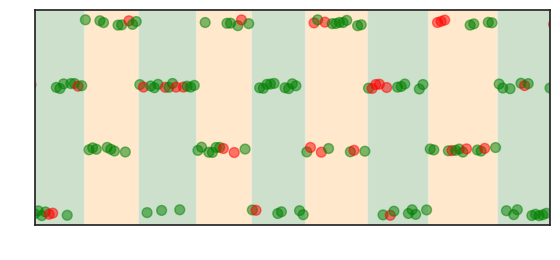

In [ ]:
for block in participant_df.block.unique():
    block_df = participant_df[participant_df['block'] == block].reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(6, 3))
    # y_labels = ['Pro Go L', 'Anti Go L', 'Pro Go R', 'Anti Go R']
    ax.set_yticks([])
    ax.set_xticks([])
    # ax.set_yticklabels(y_labels)
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')

    # Background shading along x-axis
    if background_shading:
        start_index = 0
        current_type = block_df['Air_Puff_Contingency'].iloc[0]
        for i, row in block_df.iterrows():
            if row['Air_Puff_Contingency'] != current_type:
                color = 'darkgreen' if current_type == 'Pro' else 'darkorange'
                ax.axvspan(start_index - 0.5, i - 0.5, facecolor=color, alpha=0.2)
                start_index = i
                current_type = row['Air_Puff_Contingency']
        # Shade the final block
        color = 'darkgreen' if current_type == 'Pro' else 'darkorange'
        ax.axvspan(start_index - 0.5, i + 0.5, facecolor=color, alpha=0.2)


    # Mapping conditions to y-values using a dictionary
    y_map = {
        ('Pro', 0): 0,
        ('Anti', 0): 1,
        ('Pro', 1): 2,
        ('Anti', 1): 3
    }

    colors = ['green' if correct else 'red' for correct in block_df['correct']]
    y_values = block_df.apply(lambda row: y_map.get((row['Air_Puff_Contingency'], row['choice'])), axis=1)

    # Add jitter to y-values
    y_values += np.random.uniform(-jitter, jitter, len(y_values))

    # Plotting the points
    ax.scatter(block_df.index, y_values, color=colors, s=50, alpha=0.5)


    plt.xlim(116, 258)
    # plt.title(f'Participant {subj} on {block_df.Date[0]} (Block {block})')
    plt.tight_layout()
    # save in the figures folder
    plt.savefig(figs_path + f'{subj}_Examplar_Session.pdf', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
# BReak execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

In [ ]:
try:
    df = pd.read_csv('/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/QP069/PRO_ANTI_QP069_2023_9_15/Trial_Summary2023-09-15T09_12_35.csv')
except:
    # reaise error, say that you are not connected to the server
    raise Exception('You are not connected to the server')

In [ ]:
# add 'Air_Puff_Side' column
df['Air_Puff_Side'] = np.nan
df['Air_Puff_Side'] = df.apply(pa_ut.compute_air_puff_side, axis=1)
df['choice'] = np.where(df['First_Lick']=='Right', 1, 0) # 

# Create a new column to specify y-values based on 'Air_Puff_Contingency' and 'First_Lick'
def assign_y(row):
    if row['Air_Puff_Contingency'] == 'Pro' and row['First_Lick'] == 'Left':
        return 1
    if row['Air_Puff_Contingency'] == 'Anti' and row['First_Lick'] == 'Left':
        return 2
    if row['Air_Puff_Contingency'] == 'Pro' and row['First_Lick'] == 'Right':
        return 3
    if row['Air_Puff_Contingency'] == 'Anti' and row['First_Lick'] == 'Right':
        return 4
    
# Define the bins
bins_negative = [-1.0, -0.75, -0.5, -0.25, 0.0]
bins_positive = [0.0, 0.25, 0.5, 0.75, 1.0]

# Create masks for negative and positive values
mask_negative = df['Stim_Relative'] < 0
mask_positive = df['Stim_Relative'] > 0

# Bin the negative values with left inclusivity
binned_negative = pd.cut(df[mask_negative]['Stim_Relative'], bins=bins_negative, right=False, labels = np.arange(-0.875, 0, 0.25))

# Bin the positive values with right inclusivity
binned_positive = pd.cut(df[mask_positive]['Stim_Relative'], bins=bins_positive, right=True, labels = np.arange(0.125, 1, 0.25))

# Convert the binned categories to strings
binned_negative = binned_negative.astype(str)
binned_positive = binned_positive.astype(str)

# Assign binned values using masks
df.loc[mask_negative, 'stim_relative_binned'] = binned_negative
df.loc[mask_positive, 'stim_relative_binned'] = binned_positive
# df['stim_relative_binned'] = df['stim_relative_binned'].astype('category')
df['stim_relative_binned'] = pd.to_numeric(df['stim_relative_binned'], errors='coerce')

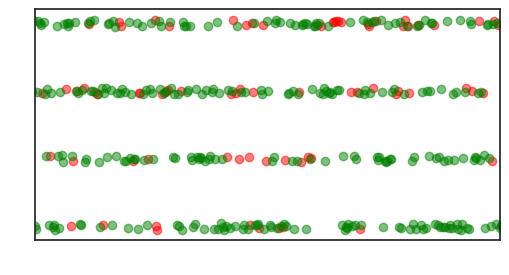

In [ ]:
p_id = 'QP069'
jitter = 0.05
valid_df = df[df.Abort_Trial == False].reset_index(drop=True)
# Plotting
fig, ax = plt.subplots(figsize=(6, 3))

valid_df['y_values'] = valid_df.apply(assign_y, axis=1)
valid_df['y_values'] += np.random.uniform(-jitter, jitter, len(valid_df['y_values']))

colors = {True: 'green', False: 'red'}
labels = {True: 'Correct', False: 'Incorrect'}

# To ensure each label is in the legend only once
handled_labels = []

for correct, group in valid_df.groupby('Correct'):
    ax.scatter(group.index, group['y_values'], color=colors[correct], 
               label=labels[correct] if labels[correct] not in handled_labels else "",
               alpha=0.5)
    handled_labels.append(labels[correct])

# Adjusting the plot
ax.set_yticks([])
ax.set_xticks([])
# ax.set_yticklabels(['Pro Go L', 'Anti Go L', 'Pro Go R', 'Anti Go R'])
ax.set_xlabel(" ")
ax.set_ylabel(" ")
ax.set_xlim(50, 410)
# ax.set_title(p_id + ' - example session')
ax.legend().remove()
# save as ped in figs_path
fig.savefig(figs_path + p_id + '_Examplar_Session.pdf', dpi=300, bbox_inches='tight')

plt.show()

## KDEs

In [182]:
df = all_data

df['Datetime'] = pd.to_datetime(df['Date'])
date_limit = '2023/09/26'  
df = df[df['Datetime'] >= date_limit]
# reference df for the first session with new protocol
# ref_df = pd.read_csv('/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/QP077/PRO_ANTI_QP077_2023_9_25/Trial_Summary2023-09-25T10_02_59.csv')
# columns_list = ref_df.columns.tolist()
columns_list = ['Animal_ID', 'Protocol', 'Stage', 'Trial_Number', 'Correct_Count', 'Sound_Contingency', 'Stim_Relative', 'Correct', 'Abort_Trial', 'Rule',
                'Reward_Side', 'First_Lick', 'Correct_Side', 'P_Right', 'Response_Latency', 'Trial_Outcome', 'Inter_Trial_Interval', 'Sound_Duration', 
                'Go_Cue_Duration', 'Stim_Type', 'Stim_Range_Min', 'Stim_Range_Max', 'Anti_Bias', 'Nb_Of_Stim', 'Response_Window', 'Timeout_Duration', 
                'Emulator', 'Distribution', 'Distribution_Exp_Rate', 'Left_Valve_Time', 'Right_Valve_Time', 'Air_Puff_Contingency', 'Window_Perf_Size', 
                'Min_Block_Length', 'Block_Performance_Threshold', 'Opto_On', 'Mask', 'Fiber', 'Perc_Opto_Trials', 'Opto_Onset_1', 'Opto_Offset_1', 
                'Air_Puff_Side', 'Opto_Onset_2', 'Opto_Offset_2', 'Trial_End_Time', 'Delay_Period',  'Working_Memory_Delay']

# Add multiple columns
columns_list.extend(['Date', 'Datetime'])
df = pa_ut.grab_columns(df, columns_list)

# combine the Delay_Period and Working_Memory_Delay columns into a single column called Working_Memory_Delay
df['Working_Memory_Delay'] = df['Working_Memory_Delay'].fillna(df['Delay_Period'])

df['Air_Puff_Side'] = df.apply(pa_ut.compute_air_puff_side, axis=1)
# df = pa_ut.add_block_column(df, participant_col = 'Animal_ID', time_col = 'Trial_End_Time', trial_col =  'Trial_Number')
df['Animal_ID'] = pd.Categorical(df['Animal_ID'], categories=Animal_List, ordered=True)
df = pa_ut.add_block_column(df, participant_col = 'Animal_ID', datetime_col = 'Datetime', trial_end_time =  'Trial_End_Time', trial_col =  'Trial_Number')
df = pa_ut.process_raw_data(df)
df = df.reset_index(drop=True)

In [183]:
def compute_kde(x_range, stimuli, choices, sigma = 0.1):
    """
    Computes the KDE for a given range of x values.
    Args:
        x_range (np.array): The range of x values to compute the KDE for
        stimuli (np.array): The array of stimuli
        choices (np.array): The array of choices
        sigma (float): The kernel width
    Returns:
        p (np.array): The KDE values for each x value    
    """
    # Calculate the distances between each x value and each stimulus
    d = np.abs(x_range[:, np.newaxis] - stimuli[np.newaxis, :])
    
    # Calculate the weights using the Gaussian kernel
    w = np.exp(-(1/2)*(d/sigma)**2)
    
    # Normalize the weights
    w = w / np.sum(w, axis=1)[:, np.newaxis]
    
    # Calculate the KDE values
    p = np.dot(w, choices)
    
    return p

def compute_bootstrap_kdes(x_range, s, c, sigma=0.1, n_bootstraps=100):
    """
    Computes the KDE for a given range of x values using bootstrapping.
    Args:
        x_range (np.array): The range of x values to compute the KDE for
        s (np.array): The array of stimuli
        c (np.array): The array of choices
        sigma (float): The kernel width
        n_bootstraps (int): The number of bootstraps to perform
    Returns:
        bootstrap_kdes (np.array): The KDE values for each x value for each bootstrap
    """
    indices = np.random.choice(len(s), size=(n_bootstraps, len(s)), replace=True)
    stimuli_resampled = s[indices]
    choices_resampled = c[indices]
    x_range_reshaped = x_range.reshape(len(x_range), 1, 1)

    # Using broadcasting for efficient computation
    d = x_range_reshaped - stimuli_resampled
    w_new = np.exp(-(1 / 2) * (d / sigma) ** 2)

    # Combining sum and division in a single step
    w_new /= np.sum(w_new, axis=2, keepdims=True)

    bootstrap_kdes = np.zeros((n_bootstraps, len(x_range)))  # Pre-allocate array for performance
    for boot in range(n_bootstraps):
        kde = np.dot(w_new[:, boot, :], choices_resampled[boot])
        bootstrap_kdes[boot] = kde  # Store the result in pre-allocated array

    return bootstrap_kdes

In [184]:
# remove no response trials
sub_df = df[df.No_response == False].reset_index(drop=True)
# remove all dara where air-puff-side or stim_relative is NaN
sub_df = sub_df.dropna(subset=['Air_Puff_Side', 'Stim_Relative']).reset_index(drop=True)
# remove all trials where Air_Puff_Contingency is Pro and Stim_Relative is positive
sub_df = sub_df[~((sub_df.Air_Puff_Contingency == 'Pro') & (sub_df.Stim_Relative > 0))].reset_index(drop=True)
# remove all trials where Air_Puff_Contingency is Anti and Stim_Relative is negative
sub_df = sub_df[~((sub_df.Air_Puff_Contingency == 'Anti') & (sub_df.Stim_Relative < 0))].reset_index(drop=True)

In [185]:
# keep continuous data
sub_df = sub_df[sub_df['Stage'] == 'Full_Task_Cont'].reset_index(drop=True)

In [10]:
air_puff_R_below_0 = sub_df[(sub_df['Air_Puff_Side'] == 'Right') & (sub_df['Stim_Relative'] < 0)]
air_puff_R_above_0 = sub_df[(sub_df['Air_Puff_Side'] == 'Right') & (sub_df['Stim_Relative'] > 0)]
air_puff_L_below_0 = sub_df[(sub_df['Air_Puff_Side'] == 'Left') & (sub_df['Stim_Relative'] < 0)]
air_puff_L_above_0 = sub_df[(sub_df['Air_Puff_Side'] == 'Left') & (sub_df['Stim_Relative'] > 0)]

x_range = np.linspace(0, 1, 50)

kde_R_below_0 = compute_kde(x_range*(-1), air_puff_R_below_0.Stim_Relative.values, air_puff_R_below_0.choice.values)
kde_R_above_0 = compute_kde(x_range, air_puff_R_above_0.Stim_Relative.values, (1-air_puff_R_above_0.choice.values))
kde_L_below_0 = compute_kde(x_range*(-1), air_puff_L_below_0.Stim_Relative.values, (1-air_puff_L_below_0.choice.values))
kde_L_above_0 = compute_kde(x_range, air_puff_L_above_0.Stim_Relative.values, air_puff_L_above_0.choice.values)

In [11]:
num_iterations = 100
boots_per_iter = 10
n = len(x_range)
kde_L_above_0_boot_tensor = np.zeros((num_iterations, boots_per_iter, n))
kde_R_above_0_boot_tensor = np.zeros((num_iterations, boots_per_iter, n))
kde_L_below_0_boot_tensor = np.zeros((num_iterations, boots_per_iter, n))
kde_R_below_0_boot_tensor = np.zeros((num_iterations, boots_per_iter, n))

for i in range(num_iterations):
    # print every 10th iteration
    if i % 10 == 0:
        print('Iteration: ', i)
    kde_R_below_0_boot_tensor[i] = compute_bootstrap_kdes(x_range = x_range*(-1),
            s = air_puff_R_below_0.Stim_Relative.values,
            c = air_puff_R_below_0.choice.values,
            sigma = 0.1,
            n_bootstraps = boots_per_iter)
    kde_R_above_0_boot_tensor[i] = compute_bootstrap_kdes(x_range = x_range,
            s = air_puff_R_above_0.Stim_Relative.values,
            c = (1-air_puff_R_above_0.choice.values),
            sigma = 0.1,
            n_bootstraps = boots_per_iter)
    kde_L_below_0_boot_tensor[i] = compute_bootstrap_kdes(x_range = x_range*(-1),
            s = air_puff_L_below_0.Stim_Relative.values,
            c = (1-air_puff_L_below_0.choice.values),
            sigma = 0.1,
            n_bootstraps = boots_per_iter)
    kde_L_above_0_boot_tensor[i] = compute_bootstrap_kdes(x_range = x_range,
            s = air_puff_L_above_0.Stim_Relative.values,
            c = air_puff_L_above_0.choice.values,
            sigma = 0.1,
            n_bootstraps = boots_per_iter)

Iteration:  0
Iteration:  10
Iteration:  20
Iteration:  30
Iteration:  40
Iteration:  50
Iteration:  60
Iteration:  70
Iteration:  80
Iteration:  90


In [12]:
kde_Pro_boot_tensor = (kde_L_below_0_boot_tensor + kde_R_below_0_boot_tensor) / 2
kde_Anti_boot_tensor = (kde_L_above_0_boot_tensor + kde_R_above_0_boot_tensor) / 2

In [13]:
# Initialize an empty DataFrame
results_df = pd.DataFrame(columns=['Participant_ID', 'Date', 
                                   'pro_125_perf', 'anti_125_perf', 'diff_125_perf',
                                   'pro_875_perf', 'anti_875_perf', 'diff_875_perf'])

for p_id in sub_df.Participant_ID.unique():
    participant_df = sub_df[sub_df.Participant_ID == p_id]
    for date in participant_df.Date.unique():
        date_df = participant_df[participant_df.Date == date]
        pro_df = date_df[date_df.Air_Puff_Contingency == 'Pro']
        anti_df = date_df[date_df.Air_Puff_Contingency == 'Anti']

        # Calculating performances
        pro_125_perf = pro_df[pro_df.stim_relative_binned == -0.125].correct.mean()
        anti_125_perf = anti_df[anti_df.stim_relative_binned == 0.125].correct.mean()
        pro_875_perf = pro_df[pro_df.stim_relative_binned == -0.875].correct.mean()
        anti_875_perf = anti_df[anti_df.stim_relative_binned == 0.875].correct.mean()

        # Calculating differences
        diff_125_perf = pro_125_perf - anti_125_perf
        diff_875_perf = pro_875_perf - anti_875_perf

        # Append to DataFrame
        results_df = results_df.append({'Participant_ID': p_id, 'Date': date,
                                        'pro_125_perf': pro_125_perf, 'anti_125_perf': anti_125_perf, 'diff_125_perf': diff_125_perf,
                                        'pro_875_perf': pro_875_perf, 'anti_875_perf': anti_875_perf, 'diff_875_perf': diff_875_perf}, 
                                       ignore_index=True)

# Optionally convert Date to datetime and sort
results_df['Date'] = pd.to_datetime(results_df['Date'])
results_df.sort_values(by=['Participant_ID', 'Date'], inplace=True)

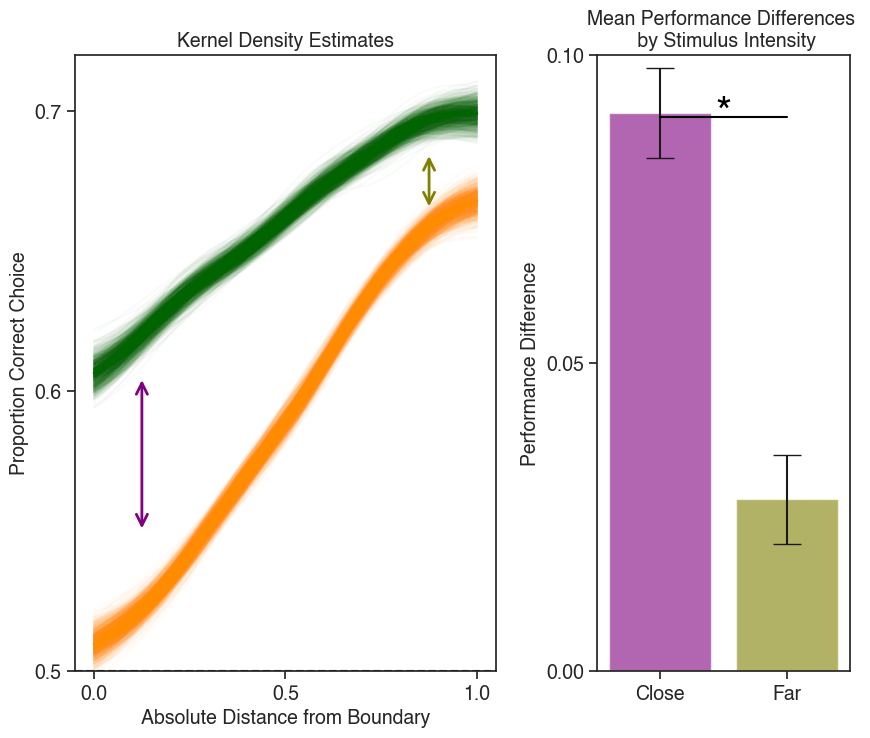

In [14]:
# Create gridspec
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5/8, 3/8]}, figsize=(10, 8))

# Plotting for the first subplot
for tensor, color in zip([kde_Pro_boot_tensor, kde_Anti_boot_tensor], ['darkgreen', 'darkorange']):
    for i in range(boots_per_iter):
        for j in range(num_iterations):
            ax1.plot(x_range, tensor[j][i], alpha=0.025, color=color)

    ax1.plot(x_range, np.mean(tensor, axis=(0,1)), color=color, linestyle='-', linewidth=2)

ax1.axhline(y=0.5, color='black', linestyle='--')
ax1.set_title('Kernel Density Estimates')
ax1.set_xlabel('Absolute Distance from Boundary')
ax1.set_ylabel('Proportion Correct Choice')
# ax1.set_yticks([0.5, 0.75])
ax1.plot([], [], color='darkgreen', label='Pro')
ax1.plot([], [], color='darkorange', label='Anti')
ax1.set_yticks([0.5, 0.6, 0.7, 0.8])
ax1.set_ylim(0.5, 0.72)
ax1.set_xticks([0, 0.5, 1])
ax1.legend().remove()
x_pos, y_start, y_length = 0.125, 0.55, 0.055
ax1.annotate('', xy=(x_pos, y_start), xytext=(x_pos, y_start + y_length),
                 arrowprops=dict(arrowstyle="<->", color='purple', linewidth=2))
x_pos, y_start, y_length = 0.875, 0.665, 0.02
ax1.annotate('', xy=(x_pos, y_start), xytext=(x_pos, y_start + y_length),
                 arrowprops=dict(arrowstyle="<->", color='olive', linewidth=2))

mean_diff_125 = results_df['diff_125_perf'].mean()
mean_diff_875 = results_df['diff_875_perf'].mean()
sem_diff_125 = results_df['diff_125_perf'].sem()
sem_diff_875 = results_df['diff_875_perf'].sem()

bar_heights = [mean_diff_125, mean_diff_875]
bar_positions = [1, 2]
# Plotting for the second subplot
ax2.bar(bar_positions, bar_heights, yerr=[sem_diff_125, sem_diff_875], color=['purple', 'olive'], alpha=0.6, label='Mean Performance', capsize=10)
ax2.set_xticks(bar_positions)
ax2.set_ylim(0, 0.1)
ax2.set_xticklabels(['Close', 'Far'])
ax2.set_xlabel(' ')
ax2.set_ylabel('Performance Difference')
ax2.set_title('Mean Performance Differences \n by Stimulus Intensity')
ax2.set_yticks([0, 0.05, 0.1])
# Adding a line to show statistical significance
x_values = [1, 2]
y_values = [0.09, 0.09]
ax2.plot(x_values, y_values, color='black')
ax2.text(1.5, y_values[0] - 0.003, "*", ha='center', va='bottom', color='black', fontsize=30)

# Adjust the spacing
plt.subplots_adjust(wspace=0.3)  # Adjust the width space between the subplots
# plt.savefig(figs_path + 'KDEs_and_perf_diff.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# BReak execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Working Memory Effect

In [ ]:
def bootstrap_ci(data, n_bootstrap=1000, ci=95):
    '''
    Calculate the confidence interval for the mean of a dataset using bootstrapping.
    Args:
        data (array): The data to use.
        n_bootstrap (int): The number of bootstrap samples to use.
        ci (int): The confidence interval to use.
    Returns:
        lower_bound (float): The lower bound of the confidence interval.
        upper_bound (float): The upper bound of the confidence interval.
    '''
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrapped_means, 100 - (100 - ci) / 2)
    return lower_bound, upper_bound

def remove_consecutive_aborts(group, threshold=30):
    """
    Removes consecutive aborts from a group.
    Args:
        group (pd.DataFrame): The group to remove consecutive aborts from.
        threshold (int): The threshold for consecutive aborts.
    Returns:
        group (pd.DataFrame): The group with consecutive aborts removed.
    """
    # Identify the start of consecutive aborts
    group['start_consecutive_abort'] = (group['Abort_Trial'] == 1) & (group['Abort_Trial'].shift(1) != 1)

    # Cumulative sum to identify unique sequences
    group['consecutive_group'] = group['start_consecutive_abort'].cumsum()

    # Count aborts in each consecutive sequence
    abort_counts = group.groupby('consecutive_group')['Abort_Trial'].transform('sum')

    # Mark rows to keep (not part of a sequence of 30+ aborts)
    group['keep'] = ~((group['Abort_Trial'] == 1) & (abort_counts >= threshold))

    return group[group['keep']]

In [ ]:
subj = 'QP0108'
dates = [
         '2023/11/09',
         '2023/11/10',
         '2023/11/11',
         '2023/11/13',
         '2023/11/14',
         '2023/11/15',
         '2023/11/16',
         '2023/11/17',
         ]
sub_df = df[(df['Participant_ID'] == subj) & (df['Date'].isin(dates))]
sub_df = sub_df[sub_df['No_response'] == False].reset_index(drop=True)
sub_df['Working_Memory_Delay'] = sub_df['Working_Memory_Delay'].fillna('00:00:00.5000000')

In [ ]:
desired_order = ['00:00:00.5000000', '00:00:00.7500000', '00:00:01']
conditions = [
    (sub_df['Air_Puff_Contingency'] == 'Pro') & (sub_df['Air_Puff_Side'] == 'Right'),
    (sub_df['Air_Puff_Contingency'] == 'Pro') & (sub_df['Air_Puff_Side'] == 'Left'),
    (sub_df['Air_Puff_Contingency'] == 'Anti') & (sub_df['Air_Puff_Side'] == 'Right'),
    (sub_df['Air_Puff_Contingency'] == 'Anti') & (sub_df['Air_Puff_Side'] == 'Left')
]

# Define the choices for each condition
choices = [
          sub_df['choice'],           # Pro and Right
          1 - sub_df['choice'],       # Pro and Left
          sub_df['choice'],           # Anti and Right
          1 - sub_df['choice']        # Anti and Left
]

# Create the new column
sub_df['Pro_Choice'] = np.select(conditions, choices, default=np.nan)

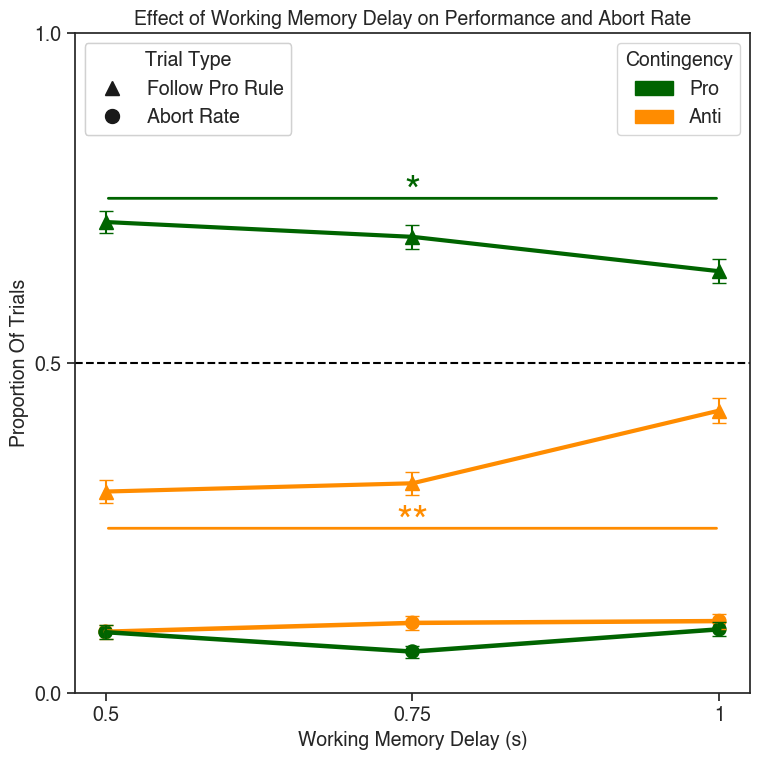

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

marker_dict = { 
    'Pro_Rate': '^',
    'Abort_Rate': 'o',
}

color_dict = {
    'Pro': 'darkgreen',
    'Anti': 'darkorange'
}

for i, contingency in enumerate(sub_df.Air_Puff_Contingency.unique()):
    contingency_df = sub_df[sub_df['Air_Puff_Contingency'] == contingency]
    label = f'{contingency}'

    # Calculate CI
    # ci_values = contingency_df.groupby('Working_Memory_Delay')['Pro_Choice'].apply(lambda x: bootstrap_ci(x, n_bootstrap=1000, ci=95))
    sem_values = contingency_df.groupby('Working_Memory_Delay')['Pro_Choice'].sem()

    # Manually plot data with triangles as markers
    x_values = np.arange(len(desired_order))  # Shift x-values to separate Pro and Anti
    y_values = contingency_df.groupby('Working_Memory_Delay')['Pro_Choice'].mean()
    
    plt.plot(x_values, y_values, marker=marker_dict['Pro_Rate'], linestyle='-', 
             color=color_dict[contingency], label=label, markersize=10,
                linewidth=3)

    # Manually adding error bars
    for j, delay in enumerate(desired_order):
        y_value = y_values[desired_order[j]]
        sem_value = sem_values[desired_order[j]]
        # lower, upper = ci_values[delay]
        # lower, upper = y_value - sem_value, y_value + sem_value
        plt.errorbar(x_values[j], y_value, yerr=[[sem_value], [sem_value]], fmt='none', 
                     ecolor=color_dict[contingency],
                     capsize=5)
        
sub_df_abort = df[(df['Participant_ID'] == subj) & (df['Date'].isin(dates))].reset_index(drop=True)
sub_df_abort['Abort_Trial'] = sub_df_abort['No_response'].astype(int)
desired_order = ['00:00:00.5000000', '00:00:00.7500000', '00:00:01']
sub_df_abort.Working_Memory_Delay = pd.Categorical(sub_df_abort.Working_Memory_Delay, categories=desired_order, ordered=True)

# remove rows if they are 30 consecutive aborts or more
sub_df_abort = sub_df_abort.groupby(['Participant_ID', 'Date']).apply(remove_consecutive_aborts).reset_index(drop=True)
sub_df_abort.drop(['start_consecutive_abort', 'consecutive_group', 'keep'], axis=1, inplace=True)

for contingency in sub_df_abort.Air_Puff_Contingency.unique():
    contingency_df = sub_df_abort[sub_df_abort['Air_Puff_Contingency'] == contingency]
    label = f'{contingency}'
    # color = 'b' if side == 'Right' else 'g'  # Choose colors as per your preference

    # Calculate CI
    # ci_values = contingency_df.groupby('Working_Memory_Delay')['Abort_Trial'].apply(lambda x: bootstrap_ci(x, n_bootstrap=1000, ci=95))
    sem = contingency_df.groupby('Working_Memory_Delay')['Abort_Trial'].sem()
    # Plot data without CI
    sns.pointplot(x='Working_Memory_Delay', y='Abort_Trial', data=contingency_df, ax=ax, ci=None, 
                  color=color_dict[contingency],
                  label=label, scale=1.2)


    # Manually adding error bars
    for i, delay in enumerate(desired_order):
        y_value = contingency_df[contingency_df['Working_Memory_Delay'] == delay]['Abort_Trial'].mean()
        # lower, upper = ci_values[delay]
        sem_value = sem[delay]

        plt.errorbar(i, y_value, yerr=[[sem_value], [sem_value]], fmt='none', 
                     ecolor=color_dict[contingency],
                     capsize=5)
        
plt.ylim(0, 1)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.ylabel('Proportion Of Trials')

plt.xlabel('Working Memory Delay (s)')
plt.xticks([0, 1, 2], ['0.5', '0.75', '1'])
plt.yticks (np.arange(0, 1.1, 0.5))
contingency_legend_labels = ['Pro', 'Anti']
contingency_legend_colors = [color_dict[label] for label in contingency_legend_labels]
contingency_legend = [mpatches.Patch(color=color, label=label) for label, color in zip(contingency_legend_labels, contingency_legend_colors)]

marker_legend_labels = ['Pro_Rate', 'Abort_Rate']
larker_actual_labels = ['Follow Pro Rule', 'Abort Rate']
marker_legend_handles = [mlines.Line2D([], [], color='k', marker=marker_dict[label], linestyle='',
                                      markersize=10, label=new_label) for label, new_label in zip(marker_legend_labels, larker_actual_labels)]

# Create two separate legend instances
legend1 = plt.legend(handles=contingency_legend, title="Contingency", loc = 'upper right')
# legend2 = plt.legend(handles=marker_legend_handles, title="Trial Type", loc='upper left')  # Add the marker meanings legend

legend2 = plt.legend(handles=marker_legend_handles, title="Trial Type", loc='upper left')
x_start, y_pos, x_length = 0, 0.25, 2
ax.annotate('', xy=(x_start, y_pos), xytext=(x_start + x_length, y_pos),
             arrowprops=dict(arrowstyle="-", color='darkorange', linewidth=2))
ax.text(1, y_pos-0.025, "**", ha='center', va='bottom', color='darkorange', fontsize=30)
x_start, y_pos, x_length = 0, 0.75, 2
ax.annotate('', xy=(x_start, y_pos), xytext=(x_start + x_length, y_pos),
             arrowprops=dict(arrowstyle="-", color='darkgreen', linewidth=2))
ax.text(1, y_pos-0.025, "*", ha='center', va='bottom', color='darkgreen', fontsize=30)
# Add the legend instances to the plot
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.title('Effect of Working Memory Delay on Performance and Abort Rate')
plt.tight_layout()
plt.savefig(figs_path + 'Effect_of_WMD_on_Perf_and_Abort.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
results_by_date = []
for date in sub_df.Date.unique():
    date_df = sub_df[sub_df['Date'] == date]
    for contingency in date_df.Air_Puff_Contingency.unique():
        contingency_df = date_df[date_df['Air_Puff_Contingency'] == contingency]
        for wm_dur in contingency_df.Working_Memory_Delay.unique():
            wm_dur_contingency_df = contingency_df[contingency_df['Working_Memory_Delay'] == wm_dur]
            ci_lower, ci_upper = bootstrap_ci(wm_dur_contingency_df['Pro_Choice'], n_bootstrap=1000, ci=95)
            

            results_by_date.append({
                'Date': date,
                'Contingency': contingency,
                'WM_Dur': wm_dur,
                'Mean': wm_dur_contingency_df['Pro_Choice'].mean(),
                'CI_Lower': ci_lower,
                'CI_Upper': ci_upper
            })

    results_by_date_df = pd.DataFrame(results_by_date)
    order = ['00:00:00.5000000', '00:00:00.7500000', '00:00:01']
    results_by_date_df = results_by_date_df.sort_values(by='WM_Dur')

In [ ]:
# perform a paired t-test to compare pro_05s and pro_1s
pro_05s = results_by_date_df[(results_by_date_df['Contingency'] == 'Pro') & (results_by_date_df['WM_Dur'] == '00:00:00.5000000')].sort_values(by='Date')['Mean']
pro_1s = results_by_date_df[(results_by_date_df['Contingency'] == 'Pro') & (results_by_date_df['WM_Dur'] == '00:00:01')].sort_values(by='Date')['Mean']
stats.ttest_rel(pro_05s, pro_1s)
print(f'p-value: for Pro 0.5 vs Pro 1 = {stats.ttest_rel(pro_05s, pro_1s)[1]}')

# perform a paired t-test to compare anti_05s and anti_1s
anti_05s = results_by_date_df[(results_by_date_df['Contingency'] == 'Anti') & (results_by_date_df['WM_Dur'] == '00:00:00.5000000')].sort_values(by='Date')['Mean']
anti_1s = results_by_date_df[(results_by_date_df['Contingency'] == 'Anti') & (results_by_date_df['WM_Dur'] == '00:00:01')].sort_values(by='Date')['Mean']
stats.ttest_rel(anti_05s, anti_1s)
print(f'p-value: for Anti 0.5 vs Anti 1 = {stats.ttest_rel(anti_05s, anti_1s)[1]}')

# perform a paired t-test to compare pro_05s to chance
stats.ttest_1samp(pro_05s, 0.5)
print(f'p-value: for Pro 0.5 vs chance = {stats.ttest_1samp(pro_05s, 0.5)[1]}')

# perform a paired t-test to compare anti_05s to chance
stats.ttest_1samp(anti_05s, 0.5)
print(f'p-value: for Anti 0.5 vs chance = {stats.ttest_1samp(anti_05s, 0.5)[1]}')

# perform a paired t-test to compare pro_1s to chance
stats.ttest_1samp(pro_1s, 0.5)
print(f'p-value: for Pro 1 vs chance = {stats.ttest_1samp(pro_1s, 0.5)[1]}')

# perform a paired t-test to compare anti_1s to chance
stats.ttest_1samp(anti_1s, 0.5)
print(f'p-value: for Anti 1 vs chance = {stats.ttest_1samp(anti_1s, 0.5)[1]}')



p-value: for Pro 0.5 vs Pro 1 = 0.043229114172617926
p-value: for Anti 0.5 vs Anti 1 = 0.0014538369063179632
p-value: for Pro 0.5 vs chance = 0.000663598305429886
p-value: for Anti 0.5 vs chance = 0.0007593917501523843
p-value: for Pro 1 vs chance = 0.00041797147220297746
p-value: for Anti 1 vs chance = 0.10997030321326444


In [ ]:
diff_results = []   
# for every date, take and store the pro_05s/pro_1s difference and the anti_05s/anti_1s difference
for date in sub_df.Date.unique():
    date_df = sub_df[sub_df['Date'] == date]
    pro_05s = date_df[(date_df['Air_Puff_Contingency'] == 'Pro') & (date_df['Working_Memory_Delay'] == '00:00:00.5000000')]['Pro_Choice'].mean()
    pro_1s = date_df[(date_df['Air_Puff_Contingency'] == 'Pro') & (date_df['Working_Memory_Delay'] == '00:00:01')]['Pro_Choice'].mean()

    anti_05s = date_df[(date_df['Air_Puff_Contingency'] == 'Anti') & (date_df['Working_Memory_Delay'] == '00:00:00.5000000')]['Pro_Choice'].mean()
    anti_1s = date_df[(date_df['Air_Puff_Contingency'] == 'Anti') & (date_df['Working_Memory_Delay'] == '00:00:01')]['Pro_Choice'].mean()

    diff_pro = abs(pro_05s - pro_1s)
    diff_pro_chance_05 = abs(pro_05s - 0.5)
    diff_pro_chance_1 = abs(pro_1s - 0.5)

    diff_anti = abs(anti_05s - anti_1s)
    diff_anti_chance_05 = abs(anti_05s - 0.5)
    diff_anti_chance_1 = abs(anti_1s - 0.5)
    
    diff_results.append({
        'Date': date,
        'Diff_Pro': diff_pro,
        'Diff_Anti': diff_anti,
        'Pro_05s': pro_05s,
        'Pro_1s': pro_1s,
        'Anti_05s': anti_05s,
        'Anti_1s': anti_1s,
        'Diff_Pro_Chance_05': diff_pro_chance_05,
        'Diff_Pro_Chance_1': diff_pro_chance_1,
        'Diff_Anti_Chance_05': diff_anti_chance_05,
        'Diff_Anti_Chance_1': diff_anti_chance_1
    })

    

diff_results_df = pd.DataFrame(diff_results)

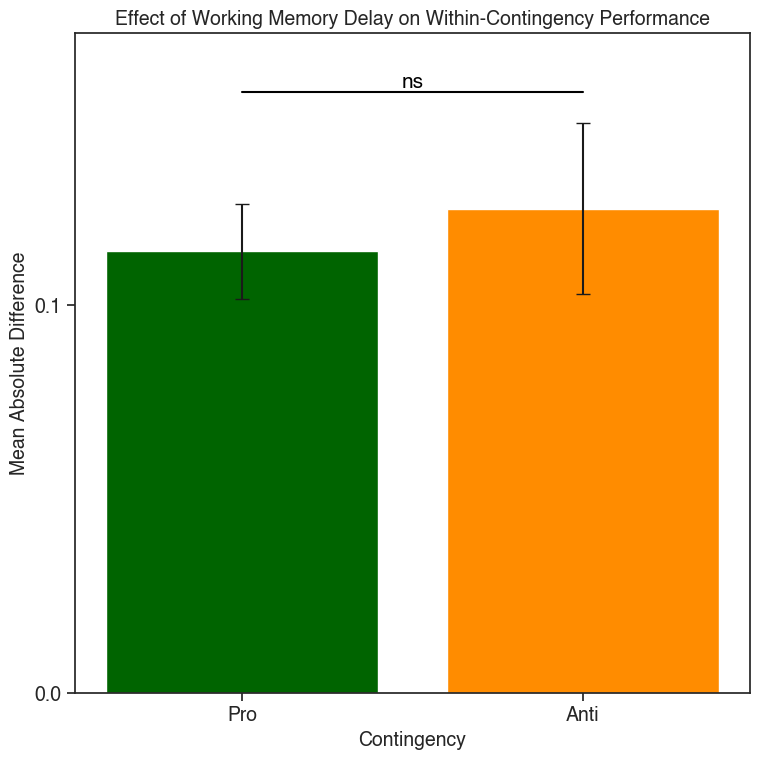

In [ ]:
# Separating Pro and Anti data
diff_pro = diff_results_df['Diff_Pro']
diff_anti = diff_results_df['Diff_Anti']

# Plotting with SEM
fig, ax = plt.subplots(figsize=(8, 8))

# Bar heights
mean_diff_pro = diff_pro.mean()
mean_diff_anti = diff_anti.mean()

# Calculate SEM (Standard Error of the Mean)
error_pro = diff_pro.sem()
error_anti = diff_anti.sem()

# Bar plot
ax.bar('Diff Pro', mean_diff_pro, yerr=error_pro, capsize=5, color=color_dict['Pro'])
ax.bar('Diff Anti', mean_diff_anti, yerr=error_anti, capsize=5, color=color_dict['Anti'])
ax.set_yticks([0, 0.1])
ax.set_ylim(0, 0.17)

# Labeling
ax.set_xlabel('Contingency')
ax.set_xticks([0, 1], ['Pro', 'Anti'])
ax.set_ylabel('Mean Absolute Difference')
ax.set_title('Effect of Working Memory Delay on Within-Contingency Performance')

x_values = [0, 1]
y_values = [0.155, 0.155]
plt.plot(x_values, y_values, color='black')
plt.text(0.5, y_values[0], "ns", ha='center', va='bottom', color='black', fontsize=15)

plt.tight_layout()
plt.savefig(figs_path + 'WMD_Difference_of_Differences.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Interrupt execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Curriculum Effects on Performance

In [ ]:
def align_dates_to_transition(participant, df, transition_dict, transition_type):
    # Create a copy of the data slice to avoid SettingWithCopyWarning
    participant_data = df[df['Participant_ID'] == participant].copy()

    # Identify the transition date for the participant
    transition_date = pd.to_datetime(transition_dict[participant][transition_type]['transition_date'])
    recovery_date = pd.to_datetime(transition_dict[participant][transition_type]['end_date'])

    # Convert dates in the dataframe to pandas datetime for arithmetic operation
    participant_data['Date'] = pd.to_datetime(participant_data['Date'])

    # Calculate relative days as integers
    participant_data['Date_Relative_Transition'] = (participant_data['Date'] - transition_date).dt.days
    participant_data['Date_Relative_Recovery'] = (participant_data['Date'] - recovery_date).dt.days

    # Convert 'Date' back to string if needed
    participant_data['Date'] = participant_data['Date'].dt.strftime('%Y/%m/%d')

    return participant_data

def reindex_relative_dates(group, reference_column):
    # Sort the dates
    sorted_dates = sorted(group[reference_column].unique())
    
    # Find the index of 0, if it exists
    zero_index = sorted_dates.index(0) if 0 in sorted_dates else None

    # Reindex negative dates
    neg_index = -1
    for i in range(zero_index - 1, -1, -1):
        if sorted_dates[i] != neg_index:
            group.loc[group[reference_column] == sorted_dates[i], reference_column] = neg_index
        neg_index -= 1

    # Reindex positive dates
    pos_index = 1
    for i in range(zero_index + 1, len(sorted_dates)):
        if sorted_dates[i] != pos_index:
            group.loc[group[reference_column] == sorted_dates[i], reference_column] = pos_index
        pos_index += 1

    return group

In [ ]:
data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
protocol = 'SOUND_CAT'
data_type = 'Trial_Summary'

Animal_List = ['QP093', 'QP094', 'QP096', 'QP097', 'QP098', 'QP099', 'QP0100', 'QP0101', 'QP0102', 'QP0103']

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_concat.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data_SC = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_SC = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = get_animal_data(data_path,
                                             animal, 
                                             protocol,
                                             data_type)
            all_data_SC = pd.concat([all_data_SC, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_SC, f)

In [ ]:
column_info = {
    'Date': {'dtype': str, 
             'rename': None, 
             'value_mapping': None},
    'Participant_ID': {'dtype': str, 
                       'rename': ['Animal_ID'], 
                       'value_mapping': None},
    'Protocol': {'dtype': str,
                 'rename': None,
                 'value_mapping': None},
    'Stage': {'dtype': str,
                'rename': None,
                'value_mapping': {'Habituation': [1, 'Habituation'],
                                  'Lick_To_Release': [2, 'Lick_To_Release'],
                                  'Three_And_Three': [3, 'Three_And_Three'],
                                  'Full_Task_Disc': [4, 'Full_Task_Disc'],
                                  'Full_Task_Cont': [5, 'Full_Task_Cont']}},
    'Trial': {'dtype': 'Int64',
                'rename': ['TrialNumber', 'Trial_Number'],
                'value_mapping': None},
    'choice': {'dtype': 'Int64', 
               'rename': ['FirstLick'], 
               'value_mapping': {0: 'Left', 1: 'Right'}},
    'Stim_Relative': {'dtype': float,
                        'rename': None,
                        'value_mapping': None},
    'correct': {'dtype': 'Int64',
                'rename': ['Correct', 'correct'],
                'value_mapping': {1: [True, '1', 'True'],
                                  0: [False, '0', 'False']}},
    'Trial_Outcome': {'dtype': str, 
                      'rename': ['TrialOutcome'], 
                      'value_mapping': {'Correct': ['Correct', 'correct', 1], 
                                        'Incorrect': ['Incorrect', 'incorrect', 0], 
                                        'No_Response': ['No Response', 'no_response', -1, 'Abort']}},
    'no_response': {'dtype': bool,
                    'rename': ['AbortTrial', 'Abort_Trial'],
                    'value_mapping': None},
    'Response_Latency': {'dtype': float,
                        'rename': None,
                        'value_mapping': None},
    'Nb_Of_Stim': {'dtype': 'Int32',
                    'rename': None,
                    'value_mapping': None},
    'Stim_Type': {'dtype': str,
                  'rename': None,
                  'value_mapping': None},
    'Anti_Bias': {'dtype': bool,
                  'rename': ['AntiBias', 'Anti_Bias'],
                  'value_mapping': None},
    'Sound_Contingency': {'dtype': str,
                          'rename': None,
                          'value_mapping': None},
    'P_Right': {'dtype': float,
                'rename': None,
                'value_mapping': None},
    'Distribution': {'dtype': str,
                     'rename': None,
                     'value_mapping': None},
    'Trial_End_Time': {'dtype': float,
                      'rename': ['Time', 'Trial_End_Time'],
                      'value_mapping': None},
    'File_ID': {'dtype': str,   
                   'rename': None,
                   'value_mapping': None},
}

all_data_cleaned = standardize_dataframe(all_data_SC, column_info)
all_data_cleaned = all_data_cleaned[all_data_cleaned['correct'].isin([0,1])]
# all_data_cleaned = all_data_cleaned[all_data_cleaned['Stage'].isin(['Full_Task_Disc'])]
all_data_cleaned['Nb_Of_Stim'] = all_data_cleaned['Nb_Of_Stim'].astype('category')

In [ ]:
# I want a dicotinary where I can have Animal ID, and then start and end dates of 2 types
# discrete-discrete transition
# discrete-continuous transition

transition_dict = {
     'QP069': {
        'discrete_discrete': {
            'start_date': '2023/08/20',
            'transition_date': '2023/08/25',
            'end_date': '2023/08/29',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
     'QP077': {
        'discrete_discrete': {
            'start_date': '2023/09/08',
            'transition_date': '2023/09/18',
            'end_date': '2023/10/18',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP083': {
        'discrete_discrete': {
            'start_date': '2023/09/07',
            'transition_date': '2023/09/13',
            'end_date': '2023/10/03',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
     'QP084': {
        'discrete_discrete': {
            'start_date': '2023/09/05',
            'transition_date': '2023/10/06',
            'end_date': '2023/10/21'
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
     'QP085': {
        'discrete_discrete': {
            'start_date': '2023/09/15',
            'transition_date': '2023/09/23',
            'end_date': '2023/09/29',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP092': {
        'discrete_discrete': {
            'start_date': '2023/09/20',
            'transition_date': '2023/09/30',
            'end_date': '2023/10/11'
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP093': {
        'discrete_discrete': {
            'start_date': '2023/08/10',
            'transition_date': '2023/08/15',
            'end_date': '2023/08/17'
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP094': {
        'discrete_discrete': {
            'start_date': '2023/08/24',
            'transition_date': '2023/08/30',
            'end_date': '2023/09/05'
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP097': {
        'discrete_discrete': {
            'start_date': '2023/08/21',
            'transition_date': '2023/08/25',
            'end_date': '2023/08/30'
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP098': {
        'discrete_discrete': {
            'start_date': '2023/08/21',
            'transition_date': '2023/08/24',
            'end_date': '2023/08/29',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },    
    'QP099': {
        'discrete_discrete': {
            'start_date': '2023/10/03',
            'transition_date': '2023/10/06',
            'end_date': '2023/10/10',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP0100': {
        'discrete_discrete': {
            'start_date': '2023/09/09',
            'transition_date': '2023/09/12',
            'end_date': '2023/09/14',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP0101': {
        'discrete_discrete': {
            'start_date': '2023/08/27',
            'transition_date': '2023/09/01',
            'end_date': '2023/09/04',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP0103': {
        'discrete_discrete': {
            'start_date': '2023/09/12',
            'transition_date': '2023/09/14',
            'end_date': '2023/09/18',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
}

In [ ]:
# remove Date == 2023/10/23 for QP084 (not enough trials)
sub_df = all_data_cleaned.reset_index(drop=True)

# remmove no_response trials
sub_df = sub_df[sub_df['no_response'] == False].reset_index(drop=True)

# Create an empty dataframe to collect all processed data
processed_data = pd.DataFrame()
p_ids = ['QP093', 'QP094', 'QP097', 'QP098', 'QP099', 'QP0100', 'QP0101', 'QP0103']
# Process data for each participant
for participant in p_ids:
    # Check if transition dates are available for the participant
    # if pd.notna(transition_dict[participant]['discrete_discrete']['start_date']):
    participant_data = align_dates_to_transition(participant, sub_df[sub_df['Participant_ID'] == participant], transition_dict, 'discrete_discrete')
    processed_data = pd.concat([processed_data, participant_data])

# Reset index of the new dataframe
sub_df = processed_data.reset_index(drop=True)

sub_df = sub_df.groupby('Participant_ID').apply(lambda x: reindex_relative_dates(x, 'Date_Relative_Transition')).reset_index(drop=True)
# only keep data where the Relative_Date is between range (inclusive)
sub_df = sub_df[(sub_df['Date_Relative_Transition'] >= -5) & (sub_df['Date_Relative_Transition'] <= 10)].reset_index(drop=True)

In [ ]:
unique_ids = sub_df['Participant_ID'].unique()
delta_rows = []

for participant_id in unique_ids:
    # Filter for the current participant
    participant_df = sub_df[sub_df['Participant_ID'] == participant_id].reset_index(drop=True)

    # Calculate baseline means
    baseline_means = participant_df[(participant_df['Date_Relative_Transition'] >= -5) 
                                    & (participant_df['Date_Relative_Transition'] < 0)].groupby('Date_Relative_Transition')['correct'].mean()

    mean_baseline_performance = baseline_means.mean()

    baseline_diff = baseline_means - mean_baseline_performance


    # Calculate differences
    means_post_transition = participant_df[(participant_df['Date_Relative_Transition'] >= 0)].groupby('Date_Relative_Transition')['correct'].mean()
    diff_post_transition = means_post_transition - mean_baseline_performance

    # Determine the range of dates to iterate over
    min_date = -5
    max_date = max(baseline_diff.index.max(), diff_post_transition.index.max())

    # Prepare data for appending
    for date in range(min_date, max_date + 1):
        date_df = participant_df[participant_df['Date_Relative_Transition'] == date]
        date_relative_recovery = date_df['Date_Relative_Recovery'].iloc[0]
        delta_rows.append({
            'Participant_ID': participant_id,
            'Date_Relative_Transition': date,
            'Date_Relative_Recovery': date_relative_recovery,
            'Baseline_Diff': baseline_diff.get(date, np.nan) if date < 0 else np.nan,
            'Diff_Post_Transition': diff_post_transition.get(date, np.nan) if date >= 0 else np.nan
        })

# Create DataFrame from list of dictionaries
delta_df = pd.DataFrame(delta_rows)

# Set appropriate data types
delta_df['Date_Relative_Transition'] = delta_df['Date_Relative_Transition'].astype(int)
delta_df['Baseline_Diff'] = delta_df['Baseline_Diff'].astype(float)
delta_df['Diff_Post_Transition'] = delta_df['Diff_Post_Transition'].astype(float)

# Optional: Sort the DataFrame
delta_df.sort_values(by=['Participant_ID', 'Date_Relative_Transition'], inplace=True)

In [ ]:
days_after_transition = 10

baseline_diff_means = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff'].mean()
baseline_diff_sems = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff'].sem()

post_transition_diff_means = delta_df[(delta_df['Date_Relative_Transition'] >= 0) 
                                & (delta_df['Date_Relative_Transition'] <= days_after_transition)].groupby('Date_Relative_Transition')['Diff_Post_Transition'].mean()
post_transition_diff_sems = delta_df[(delta_df['Date_Relative_Transition'] >= 0)
                                & (delta_df['Date_Relative_Transition'] <= days_after_transition)].groupby('Date_Relative_Transition')['Diff_Post_Transition'].sem()

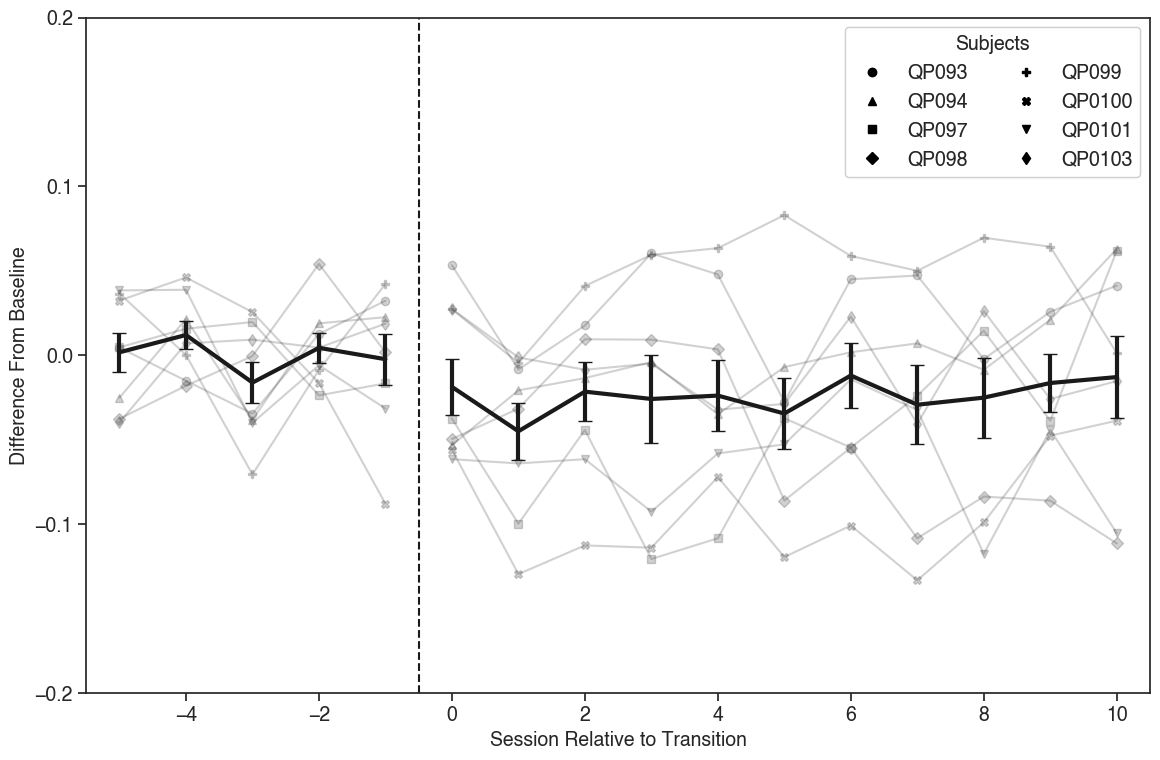

In [ ]:
marker_dict = {
                'QP093': 'o',
                'QP094': '^',
                'QP097': 's',
                'QP098': 'D',
                'QP099': 'P',
                'QP0100': 'X',
                'QP0101': 'v',
                'QP0103': 'd'
                }

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(baseline_diff_means.index, baseline_diff_means, color='k', linestyle='-', label='Baseline')
ax.errorbar(baseline_diff_means.index, baseline_diff_means, yerr=baseline_diff_sems, color='k', fmt='-', 
             capsize=5, linewidth=3)
# plot individual data points
for participant_id in unique_ids:
    participant_df = delta_df[delta_df['Participant_ID'] == participant_id]
    ax.plot(participant_df['Date_Relative_Transition'], participant_df['Baseline_Diff'],
            color='k', marker=marker_dict[participant_id], alpha=0.2)

ax.plot(post_transition_diff_means.index, post_transition_diff_means, color='k', linestyle='-', label='Post-Transition')
ax.errorbar(post_transition_diff_means.index, post_transition_diff_means, yerr=post_transition_diff_sems, color='k', fmt='-',
                capsize=5, linewidth=3)

# plot individual data points
for participant_id in unique_ids:
    participant_df = delta_df[(delta_df['Participant_ID'] == participant_id) & (delta_df['Date_Relative_Transition'] >= 0)]
    ax.plot(participant_df['Date_Relative_Transition'], participant_df['Diff_Post_Transition'],
            color='k', marker=marker_dict[participant_id], alpha=0.2)
    


ax.set_xlim(-5.5, days_after_transition + 0.5)
ax.set_ylim(-0.2, 0.2)
ax.set_yticks(np.arange(-0.2, 0.21, 0.1))
ax.set_xlabel('Session Relative to Transition')
ax.set_ylabel('Difference From Baseline')
ax.axvline(-0.5, color='k', linestyle='--')

marker_lines = [plt.Line2D([0], [0], color='black', marker=marker, linestyle='') for marker in marker_dict.values()]
marker_labels = list(marker_dict.keys())
ax.legend(marker_lines, marker_labels, loc='lower left', title='Markers', ncol=2)
ax.add_artist(ax.legend(marker_lines, marker_labels, loc='upper right', title='Subjects', ncol=2))

plt.tight_layout()
# save in the figures folder
plt.savefig(figs_path + 'Discrete_Discrete_Transition_Diff_Sound_Cat.pdf', bbox_inches = 'tight', dpi = 300)
plt.show()


In [ ]:
# Break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

In [ ]:
Animal_List = data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
protocol = 'PRO_ANTI'
data_type = 'Trial_Summary'

Animal_List = [
              'QP069', 
              'QP070', 'QP077', 'QP083', 'QP084', 'QP085', 'QP090', 'QP091', 'QP092',  'QP0104',  'QP0105', 'QP0106', 'QP0107', 'QP0108', 
              'QP0112'
              ]

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_PA.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data_PA = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_PA = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = get_animal_data(data_path,
                                             animal, 
                                             protocol,
                                             data_type)
            all_data_PA = pd.concat([all_data_PA, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_PA, f)

In [ ]:
PA_column_info = {
    'Date': {'dtype': str, 
             'rename': None, 
             'value_mapping': None},
    'Participant_ID': {'dtype': str, 
                       'rename': ['Animal_ID'], 
                       'value_mapping': None},
    'Protocol': {'dtype': str,
                 'rename': None,
                 'value_mapping': None},
    'Stage': {'dtype': str,
                'rename': None,
                'value_mapping': {'Habituation': [1, 'Habituation', 'Stage_1'],
                                  'Lick_To_Release': [2, 'Lick_To_Release', 'Stage_2'],
                                  'Three_And_Three': [3, 'Three_And_Three', 'Stage_3'],
                                  'Full_Task_Disc': [4, 'Full_Task_Disc', 'Stage_4'],
                                  'Full_Task_Cont': [5, 'Full_Task_Cont', 'Stage_5']}},
    'Trial': {'dtype': 'Int64',
              'rename': ['TrialNumber', 'Trial_Number'],
              'value_mapping': None},
    'choice': {'dtype': 'Int64', 
               'rename': ['FirstLick', 'First_Lick'], 
               'value_mapping': {0: 'Left', 1: 'Right'}},
    'Stim_Relative': {'dtype': float,
                        'rename': None,
                        'value_mapping': None},
    'correct': {'dtype': 'Int64',
                'rename': ['Correct', 'correct'],
                'value_mapping': {1: [True, '1', 'True'],
                                  0: [False, '0', 'False']}},
    'Trial_Outcome': {'dtype': str, 
                      'rename': ['TrialOutcome'], 
                      'value_mapping': {'Correct': ['Correct', 'correct', 1], 
                                        'Incorrect': ['Incorrect', 'incorrect', 0], 
                                        'No_Response': ['No Response', 'no_response', -1, 'Abort']}},
    'no_response': {'dtype': bool,
                    'rename': ['AbortTrial', 'Abort_Trial'],
                    'value_mapping': None},
    'Response_Latency': {'dtype': float,
                        'rename': None,
                        'value_mapping': None},
    'Nb_Of_Stim': {'dtype': 'Int32',
                    'rename': None,
                    'value_mapping': None},
    'Stim_Type': {'dtype': str,
                  'rename': None,
                  'value_mapping': None},
    'Anti_Bias': {'dtype': bool,
                  'rename': ['AntiBias', 'Anti_Bias'],
                  'value_mapping': None},
    'Sound_Contingency': {'dtype': str,
                          'rename': None,
                          'value_mapping': None},
    'P_Right': {'dtype': float,
                'rename': None,
                'value_mapping': None},
    'Distribution': {'dtype': str,
                     'rename': None,
                     'value_mapping': None},
    'Trial_End_Time': {'dtype': float,
                      'rename': ['Time', 'Trial_End_Time'],
                      'value_mapping': None},
    'File_ID': {'dtype': str,   
                'rename': None,
                'value_mapping': None},
    'Air_Puff_Contingency': {'dtype': str,
                             'rename': ['Trial_State'],
                             'value_mapping': {'Pro': [0],
                                                    'Anti': [1]}},
    'Air_Puff_Side': {'dtype': 'Int64', 
                      'rename': ['AirPuff_Side'],
                      'value_mapping': {1: [1, 1.0, 'Right', '1', '1.0'], 
                                        0: [0, 0.0, 'Left', '0', '0.0']}},
                                            
}

pa_df = standardize_dataframe(all_data_PA, PA_column_info)
# only keep rows where 'Participant_ID' is in Animal_List
pa_df = pa_df[pa_df['Participant_ID'].isin(Animal_List)].reset_index(drop=True)

In [ ]:
# remove Date == 2023/10/23 for QP084 (not enough trials)
sub_df = pa_df[~((pa_df['Participant_ID'] == 'QP084') & (pa_df['Date'] == '2023/10/23'))].reset_index(drop=True)

# remove the rows where Participant_ID in QP069 and Stage is Full_Task_Cont
sub_df = sub_df[~((sub_df['Participant_ID'] == 'QP069') & (sub_df['Stage'] == 'Full_Task_Cont'))].reset_index(drop=True)

# remmove no_response trials
sub_df = sub_df[sub_df['no_response'] == False].reset_index(drop=True)

# only keep rows where 'Air_Puff_Contingency' is in ['Pro', 'Anti']
sub_df = sub_df[sub_df['Air_Puff_Contingency'].isin(['Pro', 'Anti'])].reset_index(drop=True)

In [ ]:
# Create an empty dataframe to collect all processed data
processed_data = pd.DataFrame()
p_ids = ['QP069', 'QP077', 'QP083', 'QP084', 'QP085', 'QP092']
# Process data for each participant
for participant in p_ids:
    # Check if transition dates are available for the participant
    # if pd.notna(transition_dict[participant]['discrete_discrete']['start_date']):
    participant_data = align_dates_to_transition(participant, sub_df[sub_df['Participant_ID'] == participant], transition_dict, 'discrete_discrete')
    processed_data = pd.concat([processed_data, participant_data])

# Reset index of the new dataframe
sub_df = processed_data.reset_index(drop=True)

# drop rows where 'Date_Relative_Transition' or 'Date_Relative_Recovery' is NaN
sub_df = sub_df.dropna(subset=['Date_Relative_Transition']).reset_index(drop=True)
sub_df = sub_df.dropna(subset=['Date_Relative_Recovery']).reset_index(drop=True)

# Apply the reindexing function to each participant
sub_df = sub_df.groupby('Participant_ID').apply(lambda x: reindex_relative_dates(x, 'Date_Relative_Transition')).reset_index(drop=True)
sub_df = sub_df.groupby('Participant_ID').apply(lambda x: reindex_relative_dates(x, 'Date_Relative_Recovery')).reset_index(drop=True)

sub_df = sub_df[(sub_df['Date_Relative_Transition'] >= -5) & (sub_df['Date_Relative_Transition'] <= 40)].reset_index(drop=True)

In [ ]:
unique_ids = sub_df['Participant_ID'].unique()
delta_rows = []

for participant_id in unique_ids:
    # Filter for the current participant
    participant_df = sub_df[sub_df['Participant_ID'] == participant_id].reset_index(drop=True)

    # Calculate baseline means
    baseline_means = participant_df[(participant_df['Date_Relative_Transition'] >= -5) 
                                    & (participant_df['Date_Relative_Transition'] < 0)].groupby('Date_Relative_Transition')['correct'].mean()
    baseline_means_pro = participant_df[(participant_df['Date_Relative_Transition'] >= -5)
                                        & (participant_df['Date_Relative_Transition'] < 0)
                                        & (participant_df['Air_Puff_Contingency'] == 'Pro')].groupby('Date_Relative_Transition')['correct'].mean()
    baseline_means_anti = participant_df[(participant_df['Date_Relative_Transition'] >= -5)
                                        & (participant_df['Date_Relative_Transition'] < 0)
                                        & (participant_df['Air_Puff_Contingency'] == 'Anti')].groupby('Date_Relative_Transition')['correct'].mean()

    mean_baseline_performance = baseline_means.mean()

    baseline_diff = baseline_means - mean_baseline_performance
    baseline_diff_pro = baseline_means_pro - mean_baseline_performance
    baseline_diff_anti = baseline_means_anti - mean_baseline_performance


    # Calculate differences
    pro_means_post_transition = participant_df[(participant_df['Date_Relative_Transition'] >= 0) 
                                               & (participant_df['Air_Puff_Contingency'] == 'Pro')].groupby('Date_Relative_Transition')['correct'].mean()
    anti_means_post_transition = participant_df[(participant_df['Date_Relative_Transition'] >= 0) 
                                                & (participant_df['Air_Puff_Contingency'] == 'Anti')].groupby('Date_Relative_Transition')['correct'].mean()
    pro_diff_post_transition = pro_means_post_transition - mean_baseline_performance
    anti_diff_post_transition = anti_means_post_transition - mean_baseline_performance

    # Determine the range of dates to iterate over
    min_date = -5
    max_date = max(pro_diff_post_transition.index.union(anti_diff_post_transition.index).max(), -1)

    # Prepare data for appending
    for date in range(min_date, max_date + 1):
        date_df = participant_df[participant_df['Date_Relative_Transition'] == date]
        date_relative_recovery = date_df['Date_Relative_Recovery'].iloc[0]
        delta_rows.append({
            'Participant_ID': participant_id,
            'Date_Relative_Transition': date,
            'Date_Relative_Recovery': date_relative_recovery,
            'Baseline_Diff': baseline_diff.get(date, np.nan) if date < 0 else np.nan,
            'Baseline_Diff_Pro': baseline_diff_pro.get(date, np.nan) if date < 0 else np.nan,
            'Baseline_Diff_Anti': baseline_diff_anti.get(date, np.nan) if date < 0 else np.nan,
            'Pro_Diff_Post_Transition': pro_diff_post_transition.get(date, np.nan) if date >= 0 else np.nan,
            'Anti_Diff_Post_Transition': anti_diff_post_transition.get(date, np.nan) if date >= 0 else np.nan
        })

# Create DataFrame from list of dictionaries
delta_df = pd.DataFrame(delta_rows)

# Set appropriate data types
delta_df['Date_Relative_Transition'] = delta_df['Date_Relative_Transition'].astype(int)
delta_df['Baseline_Diff'] = delta_df['Baseline_Diff'].astype(float)
delta_df['Baseline_Diff_Pro'] = delta_df['Baseline_Diff_Pro'].astype(float)
delta_df['Baseline_Diff_Anti'] = delta_df['Baseline_Diff_Anti'].astype(float)
delta_df['Pro_Diff_Post_Transition'] = delta_df['Pro_Diff_Post_Transition'].astype(float)
delta_df['Anti_Diff_Post_Transition'] = delta_df['Anti_Diff_Post_Transition'].astype(float)

# Optional: Sort the DataFrame
delta_df.sort_values(by=['Participant_ID', 'Date_Relative_Transition'], inplace=True)


In [ ]:
days_after_transition = 5
days_before_recovery = 5

baseline_diff_means = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff'].mean()
baseline_diff_sems = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff'].sem()
baseline_diff_pro_means = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff_Pro'].mean()
baseline_means_pro_sems = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff_Pro'].sem()
baseline_diff_anti_means = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff_Anti'].mean()
baseline_diff_anti_sems = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff_Anti'].sem()

pro_diff_early_means = delta_df[(delta_df['Date_Relative_Transition'] >= 0) 
                                & (delta_df['Date_Relative_Transition'] <= days_after_transition)].groupby('Date_Relative_Transition')['Pro_Diff_Post_Transition'].mean()
pro_diff_early_sems = delta_df[(delta_df['Date_Relative_Transition'] >= 0)
                                & (delta_df['Date_Relative_Transition'] <= days_after_transition)].groupby('Date_Relative_Transition')['Pro_Diff_Post_Transition'].sem()

anti_diff_early_means = delta_df[(delta_df['Date_Relative_Transition'] >= 0)
                                & (delta_df['Date_Relative_Transition'] <= days_after_transition)].groupby('Date_Relative_Transition')['Anti_Diff_Post_Transition'].mean()
anti_diff_early_sems = delta_df[(delta_df['Date_Relative_Transition'] >= 0)
                                & (delta_df['Date_Relative_Transition'] <= days_after_transition)].groupby('Date_Relative_Transition')['Anti_Diff_Post_Transition'].sem()

pro_diff_late_means = delta_df[(delta_df['Date_Relative_Recovery'] >= -days_before_recovery)
                                & (delta_df['Date_Relative_Recovery'] <= 0)].groupby('Date_Relative_Recovery')['Pro_Diff_Post_Transition'].mean()

pro_diff_late_sems = delta_df[(delta_df['Date_Relative_Recovery'] >= -days_before_recovery)
                                & (delta_df['Date_Relative_Recovery'] <= 0)].groupby('Date_Relative_Recovery')['Pro_Diff_Post_Transition'].sem()

anti_diff_late_means = delta_df[(delta_df['Date_Relative_Recovery'] >= -days_before_recovery)
                                & (delta_df['Date_Relative_Recovery'] <= 0)].groupby('Date_Relative_Recovery')['Anti_Diff_Post_Transition'].mean()

anti_diff_late_sems = delta_df[(delta_df['Date_Relative_Recovery'] >= -days_before_recovery)
                                & (delta_df['Date_Relative_Recovery'] <= 0)].groupby('Date_Relative_Recovery')['Anti_Diff_Post_Transition'].sem()

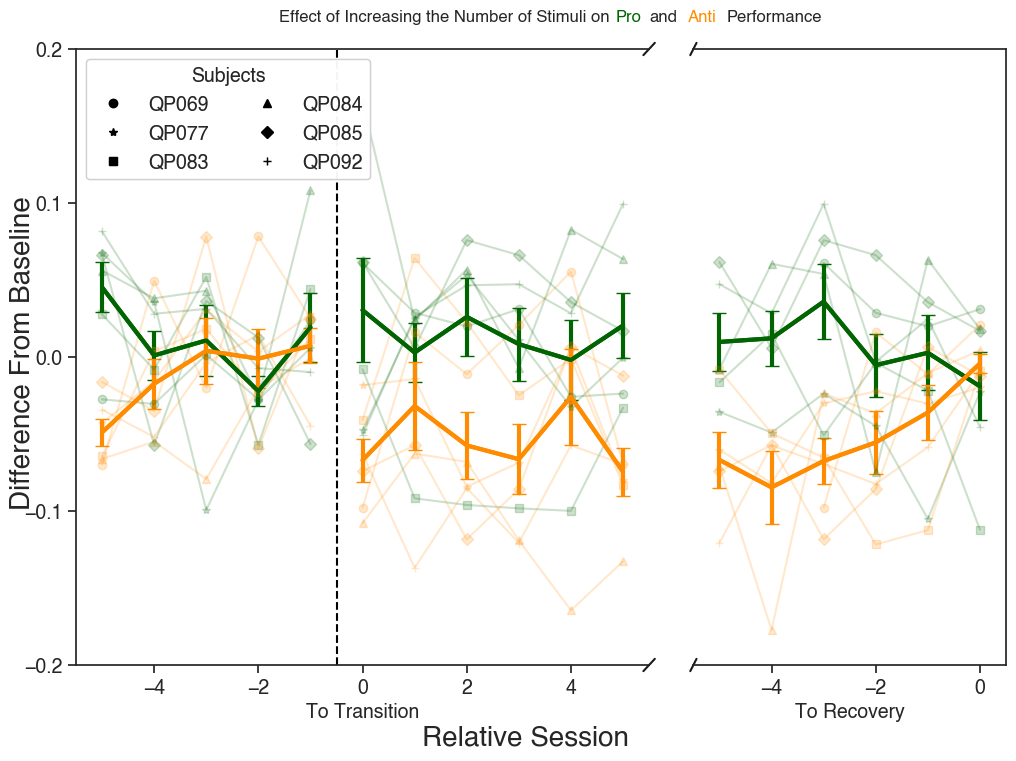

In [ ]:
color_dict = {
              'Pro': 'darkgreen', 
              'Anti': 'darkorange'}

# use markers to indicate participants
marker_dict = {'QP069': 'o',
                'QP077': '*',
                'QP083': 's',
                'QP084': '^',
                'QP085': 'D',
                'QP092': '+'}

scaling_factor = (len(baseline_diff_means) + len(pro_diff_early_means)) / len(pro_diff_late_means)
width_ratios = [scaling_factor, 1]  # Adjust these values as needed for your desired widths

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w', figsize=(12, 8),
                                 gridspec_kw={'width_ratios': width_ratios})

# ax1.plot(baseline_diff_means.index, baseline_diff_means, color='black', label='Combined')
# ax1.errorbar(baseline_diff_means.index, baseline_diff_means, yerr=baseline_diff_sems, color='black', fmt='-', capsize=5)
# plot baseline diff for pro and anti
ax1.plot(baseline_diff_pro_means.index, baseline_diff_pro_means, color= color_dict['Pro'], label='Pro', linewidth=3)
ax1.errorbar(baseline_diff_pro_means.index, baseline_diff_pro_means, yerr=baseline_means_pro_sems, color='darkgreen', fmt='-', 
             capsize=5, linewidth=3)
ax1.plot(baseline_diff_anti_means.index, baseline_diff_anti_means, color= color_dict['Anti'], label='Anti', linewidth=3)
ax1.errorbar(baseline_diff_anti_means.index, baseline_diff_anti_means, yerr=baseline_diff_anti_sems, color='darkorange', fmt='-', 
             capsize=5, linewidth=3)



# plot individual data
for participant in delta_df['Participant_ID'].unique():
    participant_data = delta_df[delta_df['Participant_ID'] == participant]
    # ax1.plot(participant_data['Date_Relative_Transition'], 
    #          participant_data['Baseline_Diff'], color= color_dict['Combined'], alpha=0.2, marker=marker_dict[participant])
    participant_data = delta_df[(delta_df['Participant_ID'] == participant) & (delta_df['Baseline_Diff_Pro'].notna())]
    ax1.plot(participant_data['Date_Relative_Transition'],
                participant_data['Baseline_Diff_Pro'], color= color_dict['Pro'],
                alpha=0.2, marker=marker_dict[participant])
    participant_data = delta_df[(delta_df['Participant_ID'] == participant) & (delta_df['Baseline_Diff_Anti'].notna())]
    ax1.plot(participant_data['Date_Relative_Transition'],
                participant_data['Baseline_Diff_Anti'], color= color_dict['Anti'],
                alpha=0.2, marker=marker_dict[participant])

ax1.plot(pro_diff_early_means.index, pro_diff_early_means, color= color_dict['Pro'], label='Pro', linewidth=3)
ax1.plot(anti_diff_early_means.index, anti_diff_early_means, color= color_dict['Anti'],label='Anti', linewidth=3)
ax1.errorbar(pro_diff_early_means.index, pro_diff_early_means, yerr=pro_diff_early_sems, color='darkgreen', fmt='-', capsize=5, linewidth=3)
ax1.errorbar(anti_diff_early_means.index, anti_diff_early_means, yerr=anti_diff_early_sems, color='darkorange', fmt='-', capsize=5, linewidth=3)
# plot individual data for pro and anti early
for participant in delta_df['Participant_ID'].unique():
    participant_data_early = delta_df[(delta_df['Participant_ID'] == participant) & (delta_df['Pro_Diff_Post_Transition'].notna())
                                      & (delta_df['Date_Relative_Transition'] <= days_after_transition)]
    ax1.plot(participant_data_early['Date_Relative_Transition'],
             participant_data_early['Pro_Diff_Post_Transition'], color= color_dict['Pro'],
                alpha=0.2, marker=marker_dict[participant])
    participant_data_early = delta_df[(delta_df['Participant_ID'] == participant) & (delta_df['Anti_Diff_Post_Transition'].notna())
                                        & (delta_df['Date_Relative_Transition'] <= days_after_transition)]
    ax1.plot(participant_data_early['Date_Relative_Transition'],
             participant_data_early['Anti_Diff_Post_Transition'], color= color_dict['Anti'],
                alpha=0.2, marker=marker_dict[participant])

ax2.plot(pro_diff_late_means.index, pro_diff_late_means, color='darkgreen', label='Pro Diff Post Transition', linewidth=3)
ax2.plot(anti_diff_late_means.index, anti_diff_late_means, color='darkorange', label='Anti Diff Post Transition', linewidth=3)
ax2.errorbar(pro_diff_late_means.index, pro_diff_late_means, yerr=pro_diff_late_sems, color='darkgreen', fmt='-', capsize=5, linewidth=3)
ax2.errorbar(anti_diff_late_means.index, anti_diff_late_means, yerr=anti_diff_late_sems, color='darkorange', fmt='-', capsize=5, linewidth=3)
# plot individual data for pro and anti late
for participant in delta_df['Participant_ID'].unique():
    participant_data_late = delta_df[(delta_df['Participant_ID'] == participant) & (delta_df['Pro_Diff_Post_Transition'].notna())
                                        & (delta_df['Date_Relative_Recovery'] >= -days_before_recovery) & (delta_df['Date_Relative_Recovery'] <= 0)]
    ax2.plot(participant_data_late['Date_Relative_Recovery'],
                participant_data_late['Pro_Diff_Post_Transition'], color= color_dict['Pro'],
                alpha=0.2, marker=marker_dict[participant])
    participant_data_late = delta_df[(delta_df['Participant_ID'] == participant) & (delta_df['Anti_Diff_Post_Transition'].notna())
                                        & (delta_df['Date_Relative_Recovery'] >= -days_before_recovery) & (delta_df['Date_Relative_Recovery'] <= 0)]
    ax2.plot(participant_data_late['Date_Relative_Recovery'],
             participant_data_late['Anti_Diff_Post_Transition'], color= color_dict['Anti'],
                alpha=0.2, marker=marker_dict[participant])

# Setting the x-axis limits
ax1.set_xlim(-5.5, days_after_transition + 0.5)
ax2.set_xlim(-days_before_recovery - 0.5, 0.5)

# Setting the y-axis limits
ax1.set_ylim(-0.2, 0.2)

# vertical line at 0
ax1.axvline(x=-0.5, color='black', linestyle='--')

# Setting the x labels
ax1.set_xlabel('To Transition')
ax2.set_xlabel('To Recovery')

# Hide the spines between ax and ax2
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
# ax2.set_yticks([])

# Explicitly set y-ticks and y-tick labels for ax1
y_ticks = np.arange(-0.2, 0.21, 0.1)
ax1.set_yticks(y_ticks)
# ax1.set_yticklabels(["{:.2f}".format(tick) for tick in y_ticks])

# Hide y-axis tick labels on ax2
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# set x ticks for ax2
ax2.set_xticks(np.arange(-4, 1, 2))

# remove y ticks from ax2
ax1.tick_params(labeltop=False)
ax2.tick_params(labeltop=False)

# Adding diagonal lines to indicate the break
d = .01
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

start_point = (4, 0.1)  # Specify the start coordinates
end_point = (4.1, 0.11)       # Specify the end coordinates


# Legend for colors
color_lines = [plt.Line2D([0], [0], color=color, lw=2) for color in color_dict.values()]
color_labels = list(color_dict.keys())
ax1.legend(color_lines, color_labels, loc='upper left', title='Colors')

# Legend for markers
marker_lines = [plt.Line2D([0], [0], color='black', marker=marker, linestyle='') for marker in marker_dict.values()]
marker_labels = list(marker_dict.keys())
ax1.legend(marker_lines, marker_labels, loc='lower left', title='Markers', ncol=2)

# Ensure the color legend stays visible
ax1.add_artist(ax1.legend(color_lines, color_labels, loc='upper left', title='Contingency')).remove()
ax1.add_artist(ax1.legend(marker_lines, marker_labels, loc='upper left', title='Subjects', ncol=2))

# Adding labels, title, and legend
ax2.legend(loc='upper right').remove()

fig.text(0.5, 0.01, 'Relative Session', ha='center')
fig.text(0.07, 0.5, 'Difference From Baseline', va='center', rotation='vertical')
# plt.suptitle('Effect of Increasing the Number of Stimuli on Pro and Anti Performance', y=0.95)

# Initial position for the first part of the title
title_height = 0.92
title_size = 12
x_pos = 0.57
# Add the first part of the title
fig.text(x_pos, title_height, "Effect of Increasing the Number of Stimuli on", ha='right', va='center', transform=fig.transFigure, fontsize=title_size)
# Adjust x_pos for the next part
x_pos += 0.005  # This value is an estimate and may need adjustment
# Add the colored parts of the title
fig.text(x_pos, title_height, "Pro", color='darkgreen', ha='left', va='center', transform=fig.transFigure, fontsize=title_size)
x_pos += 0.0275
fig.text(x_pos, title_height, "and", ha='left', va='center', transform=fig.transFigure, fontsize=title_size)
x_pos += 0.0325
fig.text(x_pos, title_height, "Anti", color='darkorange', ha='left', va='center', transform=fig.transFigure, fontsize=title_size)
x_pos += 0.0325
# Add the last part of the title
fig.text(x_pos, title_height, "Performance", ha='left', va='center', transform=fig.transFigure, fontsize=title_size)

fig.subplots_adjust(wspace=0.1)  # Adjust this value as needed
# save figure
plt.savefig(figs_path + 'Discrete_Discrete_Transition_Diff_Pro_Anti.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.